# Import libraries

In [1]:
import numpy as np
import pandas as pd
import cmasher as cmr
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.signal import resample
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import os
import itertools
from pyfuncs import *

import time as st

startdir = os.getcwd()
paperpicsdir = '/Users/leo/Desktop/ResearchPhD/PitchControl/figures/'
prespicsdir = '/Users/leo/Desktop/ResearchPhD/Presentations/SICB2022/'
%qtconsole

In [2]:
runDates = ['20210803_1','20210816_1','20210817_1','20210818_1','20210819']
mothNames = ['A','B','C','D','E','F']
mothNameDict = dict(zip(runDates, mothNames))

# Load dataframes
os.chdir(os.path.join(startdir,'preprocessedCache'))
for i,d in enumerate(runDates):
    dtemp = pd.read_hdf(d+'.h5')
    dtemp['date'] =  d
    if i==0:
        df = dtemp
    else:
        df = df.append(dtemp)
# Load other relevant variables
translations = []
for d in runDates:
    translations.append(pickleRead(os.path.join(startdir, 'preprocessedCache', 'vars')+'_'+d+'.pkl'))
# Important information that I'll just hard-code in
channelsEMG = ['LDVM', 'LDLM', 'RDLM', 'RDVM']
channelsFT = ['fx', 'fy', 'fz', 'mx', 'my', 'mz']
fsamp = 10000
# Recreate first spike columns because I don't trust them
for m in channelsEMG:
    df[m+'_fs'] = 0
    df[m+'_fs'] = df.groupby(['date','pulse','wb'], group_keys=False).apply(
        lambda g: g[m+'_fs'] + (g[m+'_st'].idxmax() - g[m+'_st'].idxmin()))
# Create first spike columns defined by phase
for m in channelsEMG:
    df[m+'_fsphase'] = 0
    df[m+'_fsphase'] = df.groupby(['date','pulse','wb'], group_keys=False).apply(
        lambda g: g[m+'_fsphase'] + g[m+'_fs'].iloc[0]/len(g))
# Define tDVM-tDLM columns
df['tdl'] = (df['LDVM_fs']-df['LDLM_fs'])/10
df['tdr'] = (df['RDVM_fs']-df['RDLM_fs'])/10
df.loc[(df['tdl']<0), 'tdl'] = np.nan
df.loc[(df['tdr']<0), 'tdr'] = np.nan

# 20210816_1 has periods where fz frequency is double spike frequency: Remove these
if '20210816_1' in runDates:
    # determine offending pulses
    issue = df.loc[(df.date=='20210816_1') &
                   (df.wbstate=='pre') &
                   (df.LDLM_st | df.RDLM_st) &
                   (df.phase<0.2)]
    droppulse = np.unique(issue.pulse)
    # Drop them
    df = df.loc[~((df.date=='20210816_1') & (df.pulse.isin(droppulse)))]

# Label pulses where first DLM pulses were due to stim (on spikephase vs stimphase diagonal)
def diagFunc(g):
    tmp = g.loc[g.wb==0,['LDLM_fsphase','RDLM_fsphase','stimphase']].iloc[0]
    returnval = True if (tmp['LDLM_fsphase']>tmp['stimphase']) and (tmp['RDLM_fsphase']>tmp['stimphase']) else False
    return g['stimfirst'] + returnval
df['stimfirst'] = False
df['stimfirst'] = df.groupby(['date','pulse'], group_keys=False).apply(diagFunc)

/var/folders/n0/lt0cwffx32q0b723pxgmg_nh0000gp/T/ipykernel_615/3578134778.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dtemp)
/var/folders/n0/lt0cwffx32q0b723pxgmg_nh0000gp/T/ipykernel_615/3578134778.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dtemp)
/var/folders/n0/lt0cwffx32q0b723pxgmg_nh0000gp/T/ipykernel_615/3578134778.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dtemp)
/var/folders/n0/lt0cwffx32q0b723pxgmg_nh0000gp/T/ipykernel_615/3578134778.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dtemp)


In [3]:
# Quick test plot
fig, ax = plt.subplots(len(runDates), 3, sharex=True)
for i,d in enumerate(runDates):
    dt = df.loc[df.date==d].copy()
    dt = dt.loc[dt.pulse==dt.pulse.iloc[0]]
    for j,m in enumerate(channelsFT[3:]):
        for jj in np.unique(dt['wb']):
            ax[i,j].plot(dt.loc[dt['wb']==jj, 'phase'], dt.loc[dt['wb']==jj, m], alpha=0.6)

# Small plots for introducing data

In [4]:
dt = df.loc[(df.date=='20210818_1') & (df.pulse==30) & (df.wb>-5) & (df.wb<5)]
mcols = ['#559EE0','#E06767','#B13028','#203864']
plt.figure()
for j in np.unique(dt['wb']):
    if j % 2 == 0:
        wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
        plt.axvspan(wbtime[0], wbtime[-1], lw=0, color='#C2C2C2')
for i,m in enumerate(channelsEMG):
    plt.plot(dt.Time, 1.5*i + dt[m], color=mcols[i])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_ticks([])

[]

In [5]:
fig, ax = plt.subplots(2,len(runDates), sharex=True, figsize=(15,5))
for i,d in enumerate(runDates):
    dt = df.loc[(df.stimfirst) & (df.wb!=0) & (df.date==d)]
    ax[0,i].hist(dt.loc[dt['LDVM_st'], 'phase'], bins=40, color='b', alpha=0.5, density=True)
    ax[0,i].hist(dt.loc[dt['RDVM_st'], 'phase'], bins=40, color='r', alpha=0.5, density=True)
    ax[1,i].hist(dt.loc[dt['LDLM_st'], 'phase'], bins=40, color='b', alpha=0.5, density=True)
    ax[1,i].hist(dt.loc[dt['RDLM_st'], 'phase'], bins=40, color='r', alpha=0.5, density=True)
    ax[0,i].set_title(d)
ax[0,0].set_ylabel('DVM')
ax[1,0].set_ylabel('DLM')
fig.text(0.06, 0.5, 'Density', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Spike Phase', ha='center')
plt.subplots_adjust(hspace=0)

/Users/leo/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


# Torques in quiescent moth trials used to make COM translations
Works as a check to indicate that COM has been found: All torques plotted should be minimized to center around 0

[0.010360564196433377, 0.004684542544934495, 0.0012292600910573626, 0.0038254002165707826, 0.0006394520123233207]


[array([11.34315774, -1.99116011, 55.0768696 ]),
 array([ 7.75505109, -5.84197762, 56.33163769]),
 array([ 8.18208076, -1.39892207, 55.71024836]),
 array([12.81044166, -2.61514537, 53.96501382]),
 array([ 4.19873859, -5.09204478, 57.27320637])]

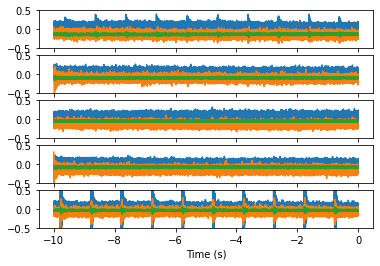

In [4]:
readFrom = 'dropbox'
fig, ax = plt.subplots(len(runDates), 1, sharex=True, sharey=True)
for ii,date in enumerate(runDates):
    # Read empty FT for bias
    biasmat, _, fsamp = readRaw(date, 'empty', doFT=True, readFrom=readFrom)
    bias = biasmat.mean(axis=0)[1:-1]
    # Use quiescent moth from stim characterization to find translation to COM
    charTrials = whichTrials(date, purpose='char', readFrom=readFrom)
    M, _, _ = readRaw(date, str(charTrials[0]).zfill(3), doFT=True, readFrom=readFrom)
    mat = M.mean(axis=0)[1:-1]
    # Apply calibration matrix and bias, get mean forces and torques for quiescent moth
    meanFT = transformFTdata((mat-bias).transpose(), M_trans=np.identity(6))
    lx,ly,lz = translations[runDates.index(date)].x
    lz = lz+20
    M_trans = np.array([
        [1,0,0,0,0,0],
        [0,1,0,0,0,0],
        [0,0,1,0,0,0],
        [0, lz, -ly, 1, 0, 0],
        [-lz, 0, lx, 0, 1, 0],
        [ly, -lx, 0, 0, 0, 1]
        ])
    new = transformFTdata((M[:,1:7]-bias).transpose(), M_trans=M_trans)
    for i in range(3):
        ax[ii].plot(M[:,0], new[:,3+i])
ax[len(runDates)-1].set_xlabel('Time (s)')
ax[0].set_ylim((-0.5,0.5))
print([translations[i].cost for i in range(len(runDates))])
[translations[i].x for i in range(len(runDates))]

# Stimulus phase vs spike times

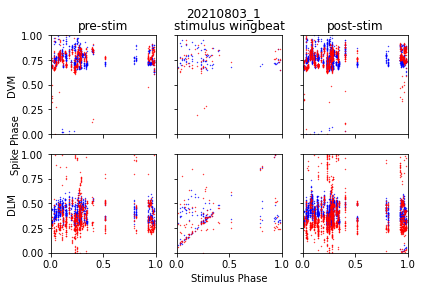

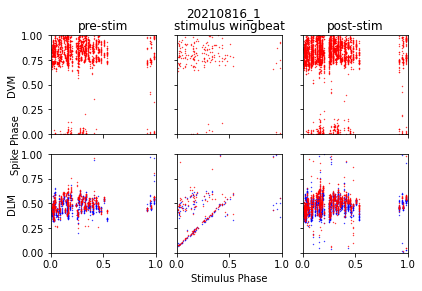

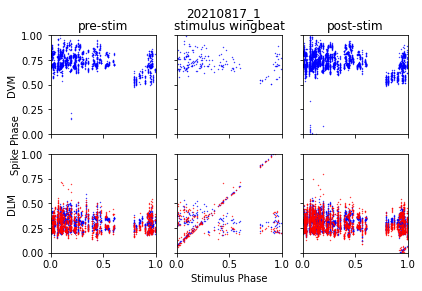

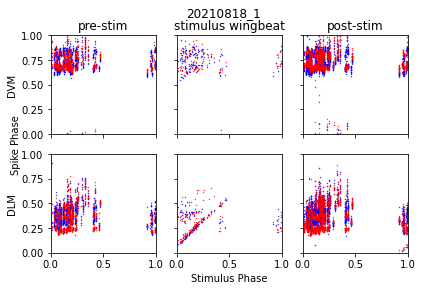

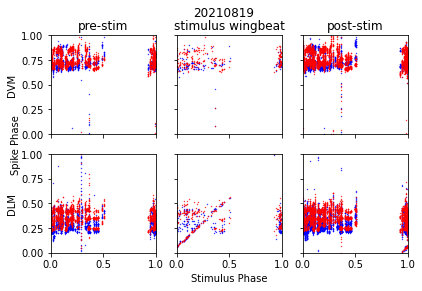

In [9]:
ms = 0.75
axnumbering = {'pre':0,'stim':1,'post':2}
for di,d in enumerate(runDates):
    # fig, ax = plt.subplots(2, 3, figsize=(10,5), sharex=True, sharey=True)
    fig, ax = plt.subplots(2, 3, figsize=(6.4,4), sharex=True, sharey=True)
    for name, g in df.loc[(df.date==d) & (df['LDVM_st'] | df['LDLM_st'] | df['RDLM_st'] | df['RDVM_st'])].groupby('wbstate'):
        i = axnumbering[name]
        # DVM subplot
        ax[0,i].plot(g.loc[g['LDVM_st'],'stimphase'], g.loc[g['LDVM_st'],'phase'], '.', color='blue', markersize=ms)
        ax[0,i].plot(g.loc[g['RDVM_st'],'stimphase'], g.loc[g['RDVM_st'],'phase'], '.', color='red', markersize=ms)
        # DLM subplot
        ax[1,i].plot(g.loc[g['LDLM_st'],'stimphase'], g.loc[g['LDLM_st'],'phase'], '.', color='blue', markersize=ms)
        ax[1,i].plot(g.loc[g['RDLM_st'],'stimphase'], g.loc[g['RDLM_st'],'phase'], '.', color='red', markersize=ms)
    for i,j in itertools.product(range(ax.shape[0]), range(ax.shape[1])):
        ax[i,j].set_xlim((0,1))
        ax[i,j].set_ylim((0,1))
    fig.suptitle(d)
    ax[0,0].set_ylabel('DVM')
    ax[1,0].set_ylabel('DLM')
    fig.text(0.04, 0.5, 'Spike Phase', va='center', rotation='vertical')
    ax[1,1].set_xlabel('Stimulus Phase')
    ax[0,0].set_title('pre-stim')
    ax[0,1].set_title('stimulus wingbeat')
    ax[0,2].set_title('post-stim')


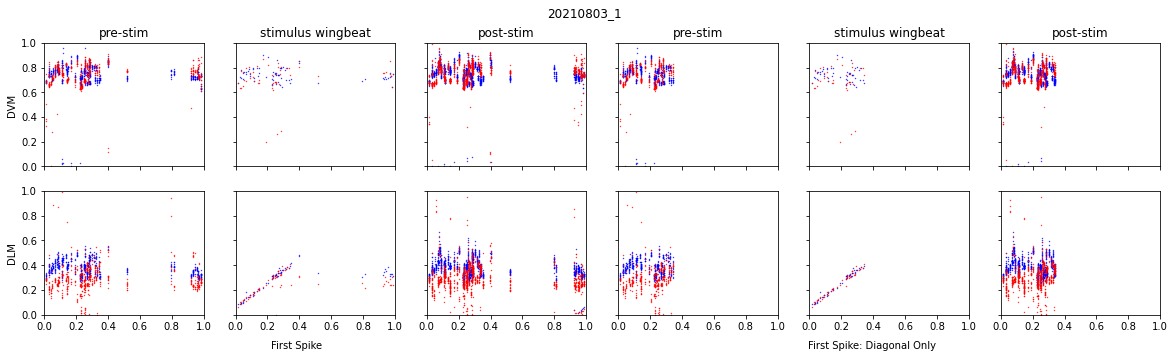

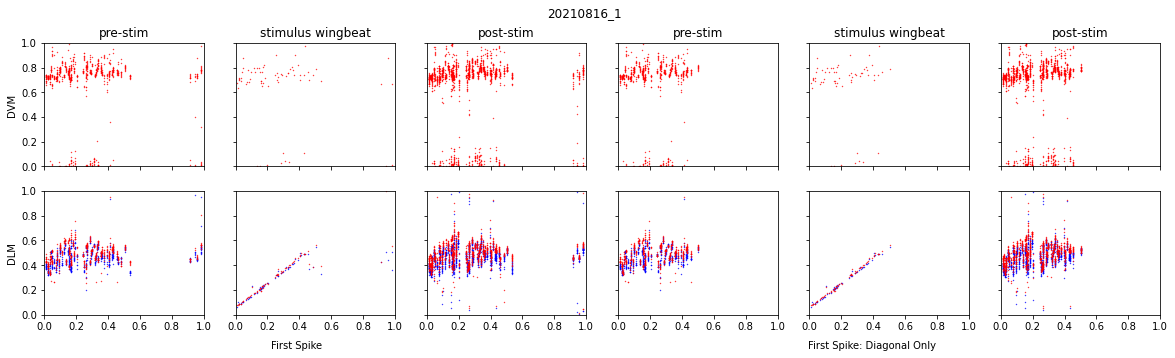

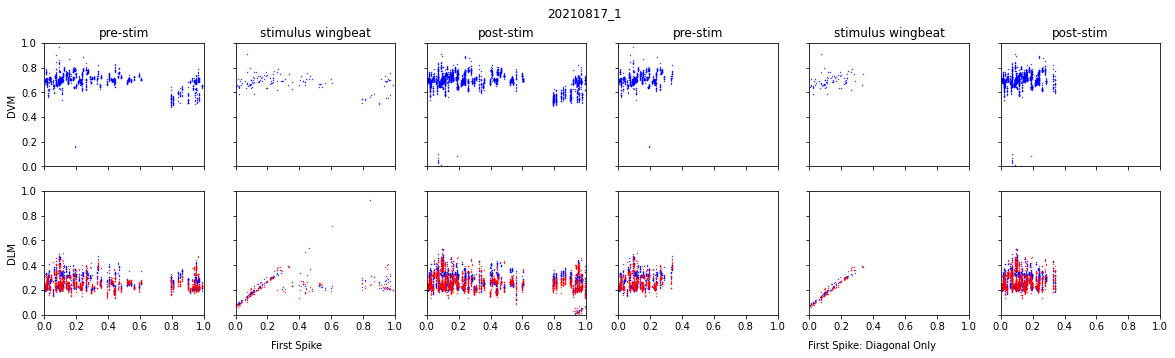

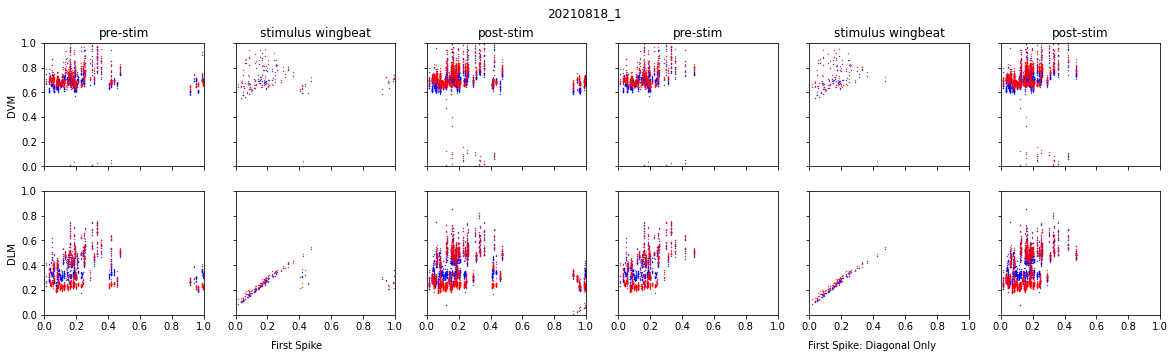

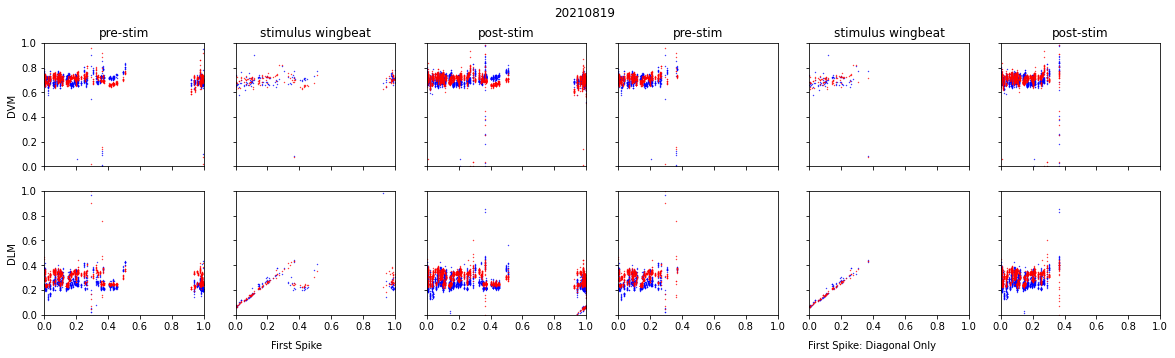

In [4]:
ms = 0.75
axnumbering = {'pre':0,'stim':1,'post':2}
for di,d in enumerate(runDates):
    fig, ax = plt.subplots(2, 6, figsize=(20,5), sharex=True, sharey=True)
    for name, g in df.loc[df.date==d].groupby('wbstate'):
        dt = g.groupby(['pulse','wb']).aggregate('first')
        j = axnumbering[name]
        for m in channelsEMG:
            i = 0 if 'V' in m else 1
            col = 'blue' if m[0]=='L' else 'red'
            ax[i,j].plot(dt.loc[dt[m+'_fs']!=0,'stimphase'], dt.loc[dt[m+'_fsphase']!=0,m+'_fsphase'],
                         '.', color=col, markersize=ms)
        dt = dt.loc[dt.stimfirst]
        for m in channelsEMG:
            i = 0 if 'V' in m else 1
            col = 'blue' if m[0]=='L' else 'red'
            ax[i,j+3].plot(dt.loc[dt[m+'_fs']!=0,'stimphase'], dt.loc[dt[m+'_fsphase']!=0,m+'_fsphase'],
                         '.', color=col, markersize=ms)
    for i,j in itertools.product(range(ax.shape[0]), range(ax.shape[1])):
        ax[i,j].set_xlim((0,1))
        ax[i,j].set_ylim((0,1))
    fig.suptitle(d)
    ax[0,0].set_ylabel('DVM')
    ax[1,0].set_ylabel('DLM')
    fig.text(0.30, 0.03, 'First Spike', ha='center')
    fig.text(0.7, 0.03, 'First Spike: Diagonal Only', ha='center')
    ax[0,0].set_title('pre-stim')
    ax[0,1].set_title('stimulus wingbeat')
    ax[0,2].set_title('post-stim')
    ax[0,3].set_title('pre-stim')
    ax[0,4].set_title('stimulus wingbeat')
    ax[0,5].set_title('post-stim')


# Estimating "actual pitch" from pitch torque


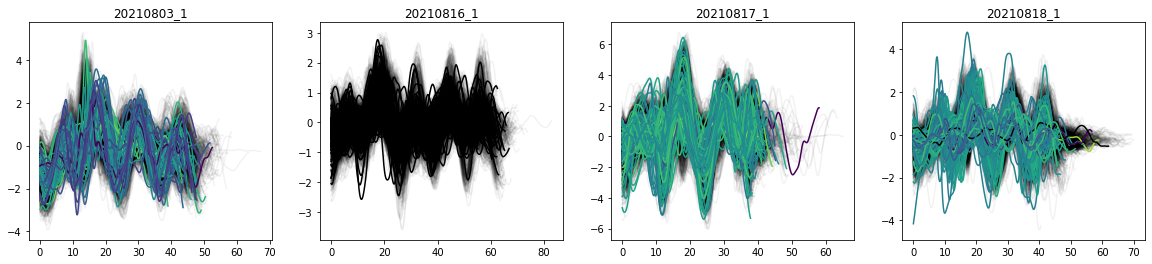

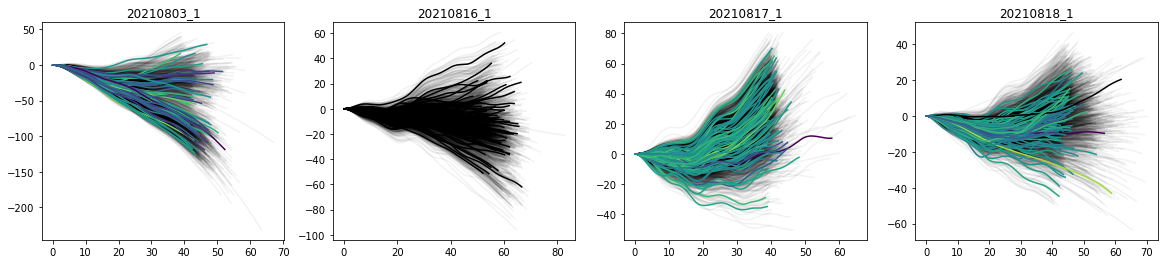

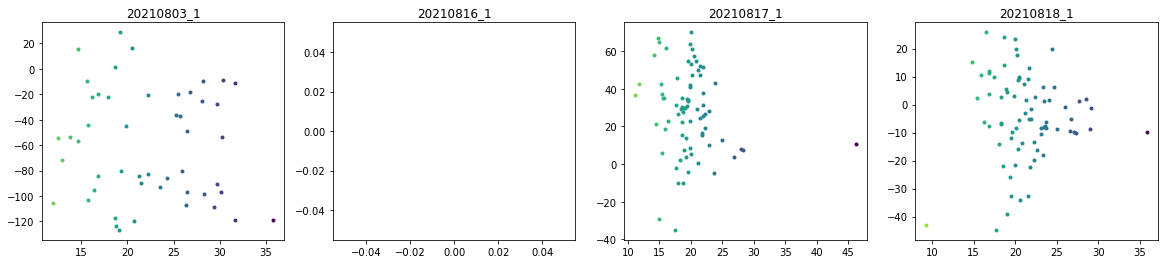

In [6]:
Iyy = 266.7*1e-09 # gmm^2 to kg m^2

figMoment, axMoment = plt.subplots(1, len(runDates), figsize=(20,4))
figTheta, axTheta = plt.subplots(1, len(runDates), figsize=(20,4))
figft, axft = plt.subplots(1, len(runDates), figsize=(20,4))
viridis = cmx.get_cmap('viridis')
mincol, maxcol = 5, 36

for i, (dname, dg) in enumerate(df.loc[df.stimfirst].groupby('date')):
    for name, g in dg.groupby(['pulse','wb']):
        tvec = 1000*(g.Time - g.Time.iloc[0])
        # if len(g.loc[g['LDVM_st'], 'Time'])!=0:
        # tvec = 1000*(g.Time - g.loc[g['LDVM_st'], 'Time'].iloc[0])
        theta = cumtrapz(cumtrapz(g.mx/1000/Iyy, dx=1/fsamp), dx=1/fsamp)*180/np.pi
        thiswbstate = g.wbstate.iloc[0]
        if thiswbstate=='stim':
            yvar = g['tdl'].iloc[0]
            colvar = (maxcol - yvar)/(maxcol - mincol)
            axTheta[i].plot(tvec[:-2], theta, color=viridis(colvar), alpha=1, zorder=1)
            axMoment[i].plot(tvec, g.mx, color=viridis(colvar), alpha=1, zorder=1)
            axft[i].plot(yvar, theta[-1], '.', color=viridis(colvar))
        else:
            axTheta[i].plot(tvec[:-2], theta, color='black', alpha=0.05, zorder=0)
            axMoment[i].plot(tvec, g.mx, color='black', alpha=0.05, zorder=0)
    axTheta[i].set_title(dname)
    axMoment[i].set_title(dname)
    axft[i].set_title(dname)

# Phase-aligned vs. spike-aligned torque waveforms

Inspired by figure 2 of Simon's 2015 PLS paper; compare waveform alignment when aligned by wingbeat phase (zero crossing of hilbert transform) vs when aligned by first spike timing of a given muscle

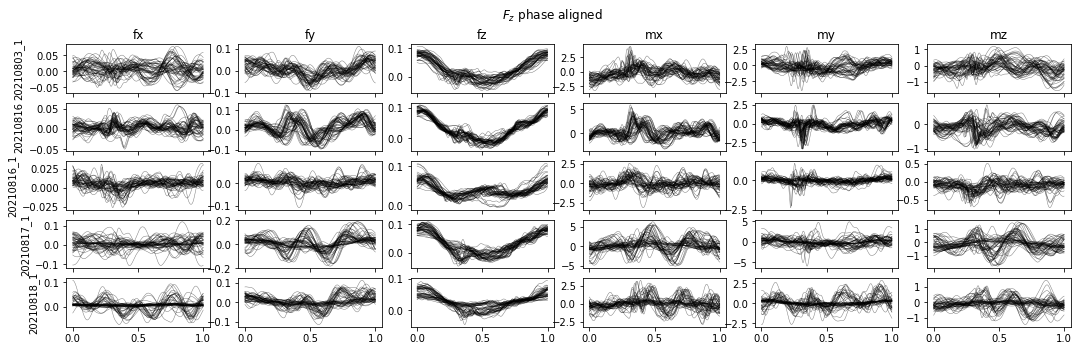

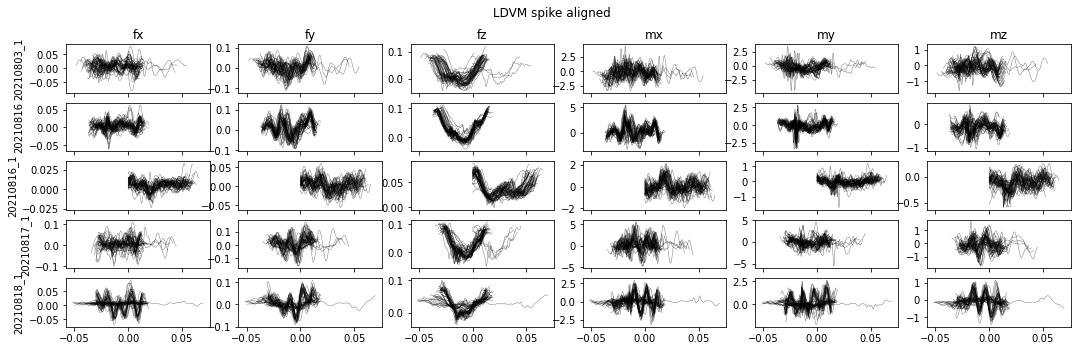

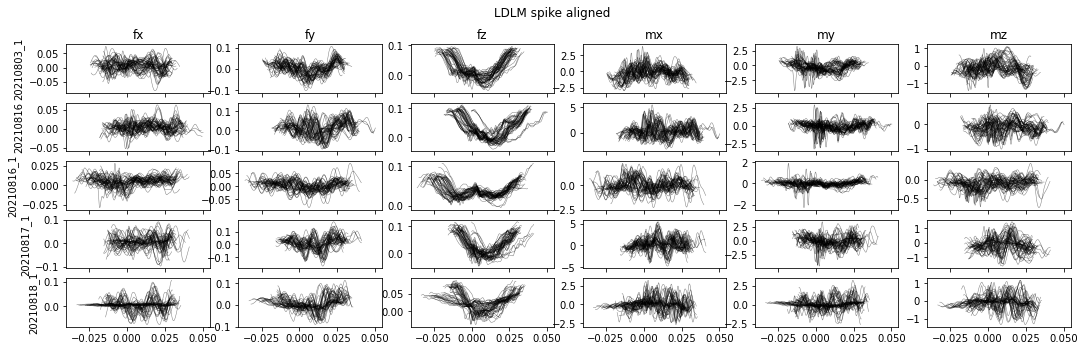

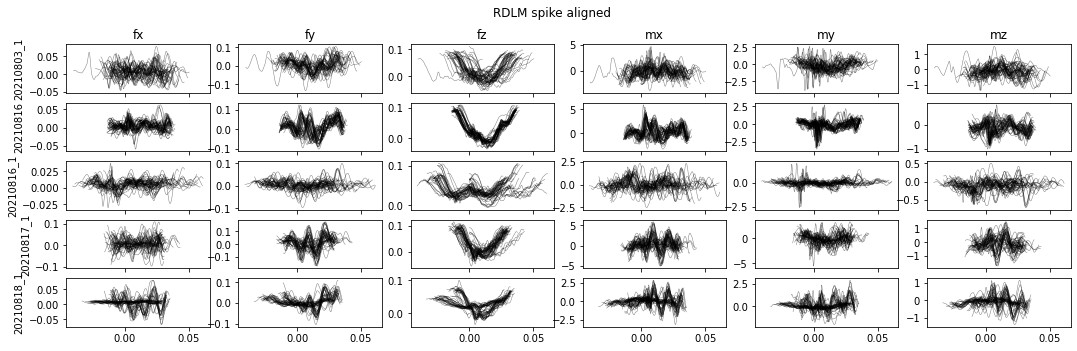

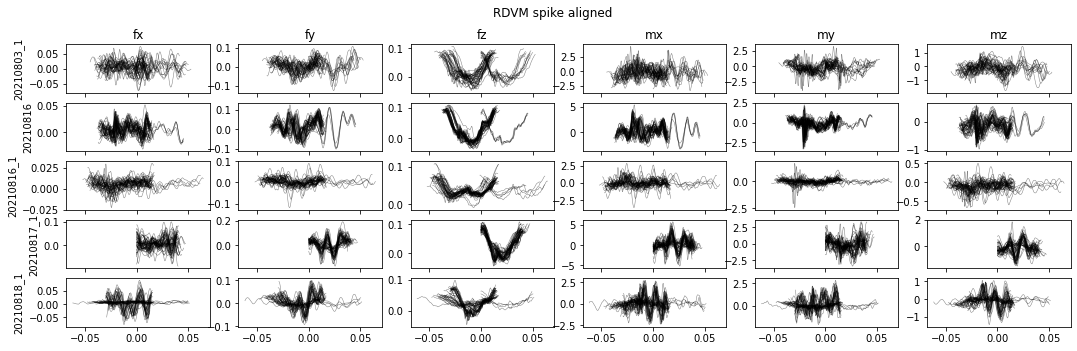

In [14]:
nwb = 50 # How many wingbeats to sample
fsize = (18, 5.2)

#--- Fz phase aligned
fig, ax = plt.subplots(len(runDates), len(channelsFT), figsize=fsize, sharex=True)
for i,d in enumerate(runDates):
    # grab this date
    dt = df.loc[(df.date==d) & (df.wb<-1),].copy()
    # Index the groups, select random subset
    g = dt.groupby(['pulse','wb'])
    a = np.arange(g.ngroups)
    np.random.shuffle(a)
    dt = dt[g.ngroup().isin(a[:nwb])]
    # Loop over randomly chosen groups and plotting variables, and plot
    for name, group in dt.groupby(['pulse','wb']):
        for j,m in enumerate(channelsFT):
            ax[i,j].plot(group.phase, group[m],
                         lw=0.5, alpha=0.5, color='black')
fig.suptitle(r'$F_z$ phase aligned')
for i,m in enumerate(channelsFT):
    ax[0,i].set_title(m)
for i,d in enumerate(runDates):
    ax[i,0].set_ylabel(d)

#--- First spike aligned
for alignMuscle in channelsEMG:
    fig, ax = plt.subplots(len(runDates), len(channelsFT), figsize=fsize, sharex=True)
    for i,d in enumerate(runDates):
        # Grab data
        dt = df.loc[(df.date==d) & (df.wb<-1) & (~np.isnan(df[alignMuscle+'_fs']))].copy()
        # Continue only if aligning muscle had data 
        if len(dt)!=0:
            # Index the groups, select random subset
            g = dt.groupby(['pulse','wb'])
            a = np.arange(g.ngroups)
            np.random.shuffle(a)
            dt = dt[g.ngroup().isin(a[:nwb])]
            # Loop over randomly chosen groups and plotting variables, and plot
            for name, group in dt.groupby(['pulse','wb']):
                for j,m in enumerate(channelsFT):
                    ax[i,j].plot(group.Time-group.Time.iloc[int(group[alignMuscle+'_fs'].iloc[0])],
                                group[m],
                                lw=0.5, alpha=0.5, color='black')
    fig.suptitle(alignMuscle+' spike aligned')
    for i,m in enumerate(channelsFT):
        ax[0,i].set_title(m)
    for i,d in enumerate(runDates):
        ax[i,0].set_ylabel(d)


# Stimulation methods figure

### Stimulation example plot

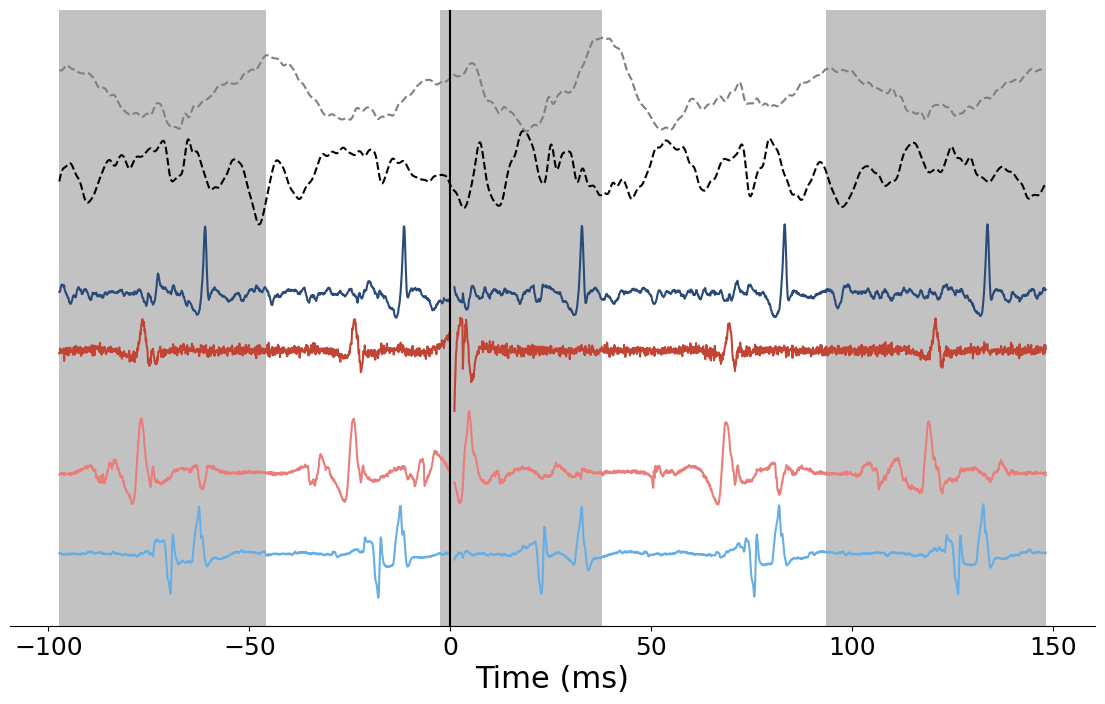

In [174]:
backShadeColor = '#C2C2C2'
muscleCols = ['#66AFE6','#E87D7A','#C14434','#2A4A78']
dt = df.loc[
    (df.wb>-3) & (df.wb<3) &
    (df.date=='20210818_1')
]
# dt = dt.loc[dt.pulse==np.random.choice(np.unique(dt.pulse))] # for choosing random stim pulses
dt = dt.loc[dt.pulse==99] # 65, 99 illustrate well
dt.Time -= dt.Time.iloc[np.argmax(dt.stim)]
dt.Time *= 1000
with plt.style.context('default'):
    plt.figure(figsize=(14,8))
# Plot EMGs
for i,m in enumerate(channelsEMG):
    ymin, ymax = np.nanmin(dt[m]), np.nanmax(dt[m])
    plt.plot(dt.Time, i+(dt[m]-ymin)/(ymax-ymin), color=muscleCols[i])
# Plot Mx, Fz
ymin, ymax = np.nanmin(dt.mx), np.nanmax(dt.mx)
plt.plot(dt.Time, (dt.mx-ymin)/(ymax-ymin)+4, '--', color='black')
ymin, ymax = np.nanmin(dt.fz), np.nanmax(dt.fz)
plt.plot(dt.Time, (dt.fz-ymin)/(ymax-ymin)+5, '--', color='grey')
# Plot wingbeat shading blocks, stimulus bar
for j in np.unique(dt['wb']):
    wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
    if j % 2 == 0:
        plt.axvspan(wbtime[0], wbtime[-1], lw=0, color=backShadeColor)
plt.axvline(x=dt.Time.iloc[np.where(np.isnan(dt.LDVM))[0][0]], color='black')
ax = plt.gca()
ax.get_yaxis().set_ticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Time (ms)', fontsize=22)
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.savefig(paperpicsdir+'stim_methods_example.pdf')

### Proof of stimulation working panel 

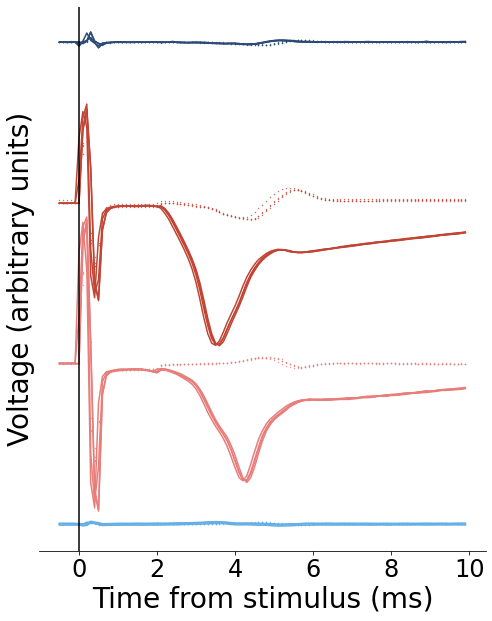

In [76]:
date = '20210819'
muscleCols = ['#66AFE6','#E87D7A','#C14434','#2A4A78']
# greyMuscleCols = ['#B6D1E6', '#E8BAB9', '#B08079', '#616A78']
linestyleList = ['-','.']
readFrom = 'dropbox'
windowlen, initwindow = 100, -5
offset = 3
plotMuscles = ['LDVM', 'LDLM', 'RDLM', 'RDVM']
fig = plt.figure(figsize=(8,10))
# Get list of characterization trials
charTrials = whichTrials(date, purpose='char', readFrom=readFrom)
# Loop over char trials, grab data after stim and add to plot
for i, tr in reversed(list(enumerate(charTrials[0:2]))): # (Reversed b/c this date starts at high current and goes lower)
    data, names, fsamp = readRaw(date, str(tr).zfill(3), readFrom=readFrom)
    stiminds = np.where(np.logical_and(data[:,-1] > 3, np.roll(data[:,-1] < 3, 1)))[0]
    # Loop over muscles
    for j in range(4): 
        muscleind = names.index(plotMuscles[j])
        # Loop over stimulation pulses
        for k in stiminds[1:5]: # Plot the first 5 because we only need a few examples
            plt.plot(
                np.arange(initwindow, windowlen) / 10,
                data[(k+initwindow):(k+windowlen),muscleind] + j * offset,
                linestyleList[i], markersize=0.75,
                color=muscleCols[j]
                )
# Plot aesthetics
plt.axvline(0, color='black')
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([])
ax.tick_params(axis='both', labelsize=24)
ax.set_xlabel('Time from stimulus (ms)', fontsize=28)
ax.set_ylabel('Voltage (arbitrary units)', fontsize=28)
fig.savefig(paperpicsdir+'stim_methods_characterization_example.pdf')

### Stim phase vs spike times

In [232]:
ms = 1
fig, ax = plt.subplots(len(runDates), 2, figsize=(6,11), sharex=True, sharey=True)
for di,d in enumerate(runDates):
    g = df.loc[(df.date==d) & (df.wbstate=='stim') & (df.stimfirst) & (df['LDVM_st'] | df['LDLM_st'] | df['RDLM_st'] | df['RDVM_st'])]
    # DVM subplot
    ax[di,0].plot(g.loc[g['LDVM_st'],'stimphase'], g.loc[g['LDVM_st'],'phase'], '.', color='blue', markersize=ms)
    ax[di,0].plot(g.loc[g['RDVM_st'],'stimphase'], g.loc[g['RDVM_st'],'phase'], '.', color='red', markersize=ms)
    # DLM subplot
    ax[di,1].plot(g.loc[g['LDLM_st'],'stimphase'], g.loc[g['LDLM_st'],'phase'], '.', color='blue', markersize=ms)
    ax[di,1].plot(g.loc[g['RDLM_st'],'stimphase'], g.loc[g['RDLM_st'],'phase'], '.', color='red', markersize=ms)
    # Labels 
    ax[di,0].set_ylabel('Moth ' + mothNameDict[d], fontsize=12)
    ax[di,0].set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax[di,0].set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])
ax[0,0].set_title('DVM', fontsize=16)
ax[0,1].set_title('DLM', fontsize=16)
fig.subplots_adjust(left=0.2, bottom=0.085, hspace=0.0, wspace=0.04)
ax[len(runDates)-1,0].set_xticks([0, 0.25, 0.5, 0.75, 1])
ax[len(runDates)-1,0].set_xticklabels(['0', '0.25', '0.5', '0.75', '1'])
fig.text(0.04, 0.5, 'Spike Phase', va='center', rotation='vertical', fontsize=15)
fig.text(0.54, 0.04, 'Stimulus Phase', ha='center', fontsize=15)
fig.savefig(paperpicsdir+'stim_methods_spikephase_vs_stimphase.pdf')

## Show distributions of stimulation phase

(array([0.01247518, 0.00554452, 0.06653427, 0.68890696, 2.86929057,
        2.7126578 , 3.9629477 , 3.02453721, 2.92750806, 2.11384933,
        1.2142505 , 0.47682896, 0.14277146, 0.06376201, 0.02910874,
        0.00970291, 0.00693065, 0.00554452, 0.01386131, 0.01386131]),
 array([0.01598174, 0.06509554, 0.11420935, 0.16332315, 0.21243696,
        0.26155076, 0.31066457, 0.35977837, 0.40889218, 0.45800598,
        0.50711979, 0.55623359, 0.6053474 , 0.6544612 , 0.70357501,
        0.75268881, 0.80180262, 0.85091642, 0.90003023, 0.94914403,
        0.99825784]),
 <BarContainer object of 20 artists>)

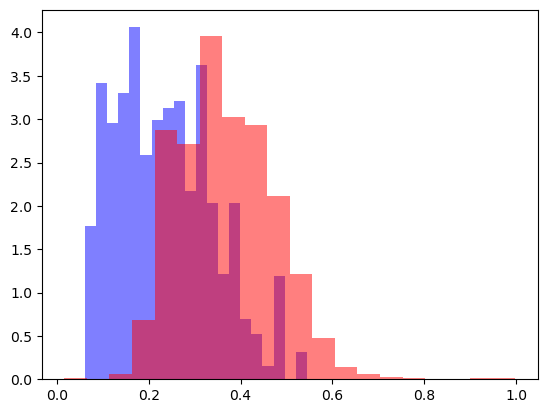

In [28]:
usewb = (-1, 2) # ignore all wingbeat except in this range
# fig, ax = plt.subplots(1, len(runDates), sharex=True, figsize=(15,5))
fig = plt.figure()
ax = plt.gca()

# Loop over dates
# for di,d in enumerate(runDates):
# make dataframe subset
dt = df.loc[(df.wbstate == 'stim') & (df.stimfirst)].copy()
# Generate y axis vector
dt['yvar'] = 0
dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'LDLM_fsphase'].iloc[0]))
ax.hist(dt.yvar, bins=20, density=True, alpha=0.5, color='b')
ax.hist(df.loc[(df.wb!=0) & (df.stimfirst) & df.LDLM_st, 'phase'], bins=20, density=True, alpha=0.5, color='r')

In [27]:
df.head()

Time      LDVM      LDLM      RDLM      RDVM      stim        fx  \
648809 -15.1191 -0.028177 -0.037736 -0.018173  0.029146  0.010388  0.020933   
648810 -15.1190 -0.017431  0.003762 -0.004014  0.050539  0.024883  0.021918   
648811 -15.1189 -0.013136  0.028186  0.007278  0.050053  0.013609  0.022772   
648812 -15.1188 -0.013682 -0.014069 -0.006201  0.032842  0.004590  0.023485   
648813 -15.1187 -0.012307  0.017761  0.004187  0.033051  0.004268  0.024077   

              fy        fz        mx  ...  LDLM_fs  RDLM_fs  RDVM_fs  \
648809  0.028127  0.085869 -0.712898  ...        0      150      461   
648810  0.028051  0.086692 -0.746049  ...        0      150      461   
648811  0.027986  0.087583 -0.766416  ...        0      150      461   
648812  0.027907  0.088526 -0.775676  ...        0      150      461   
648813  0.027790  0.089447 -0.776984  ...        0      150      461   

        LDVM_fsphase  LDLM_fsphase  RDLM_fsphase RDVM_fsphase   tdl   tdr  \
648809      0.841713           0.0       0.27933     0.858473  45.2  31.1   
648810      0.841713           0.0       0.27933     0.858473  45.2  31.1   
648811      0.841713           0.0       0.27933     0.858473  45.2  31.1   
648812      0.841713           0.0       0.27933     0.858473  45.2  31.1   
648813      0.841713           0.0       0.27933     0.858473  45.2  31.1   

        stimfirst  
648809      False  
648810      False  
648811      False  
648812      False  
648813      False  

[5 rows x 35 columns]

## Qualitative effects of stimulation on pitch torque plots

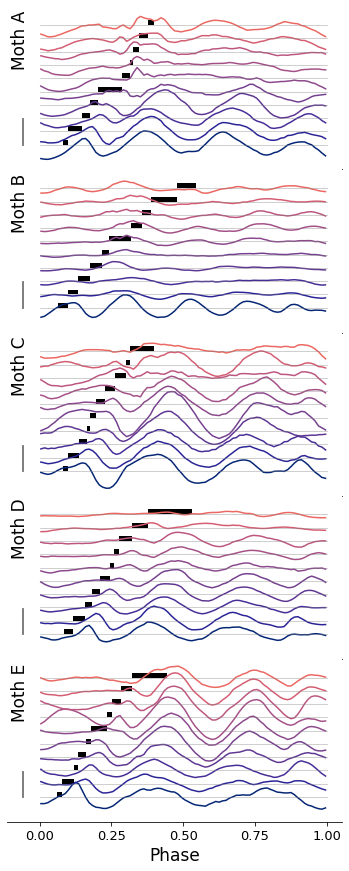

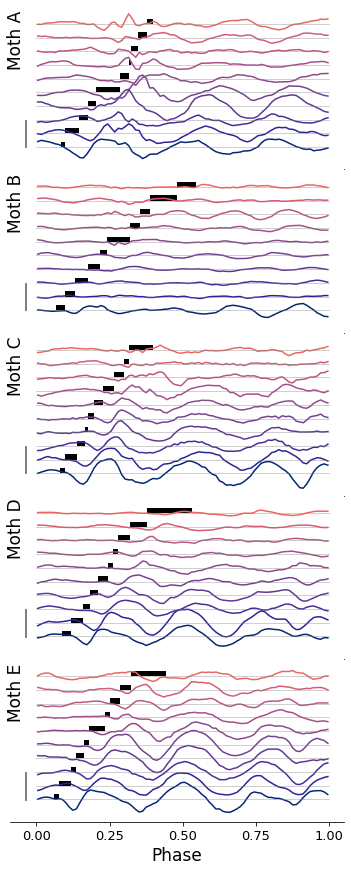

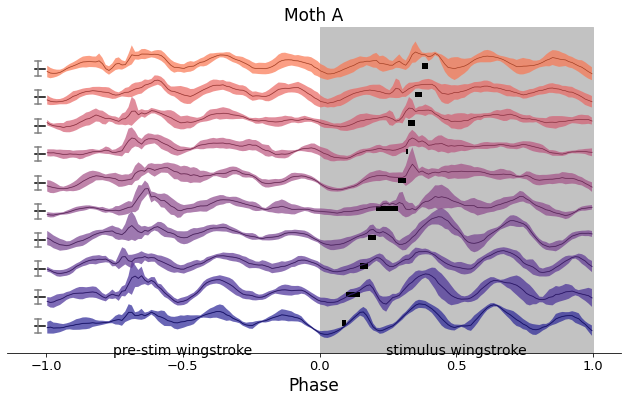

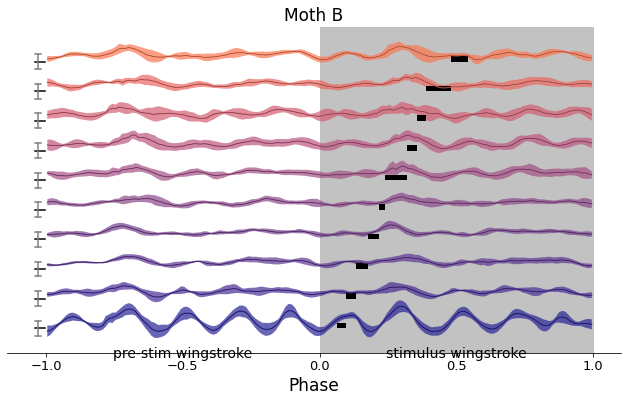

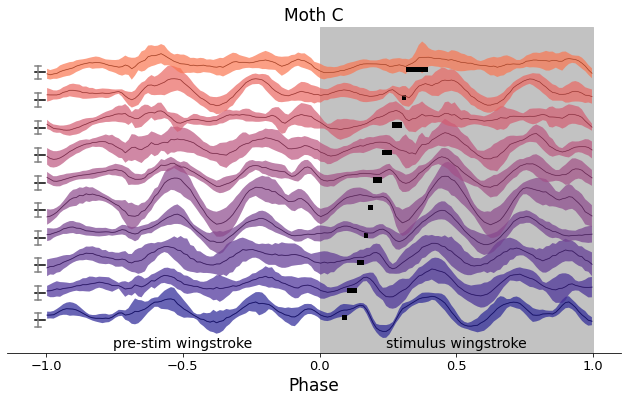

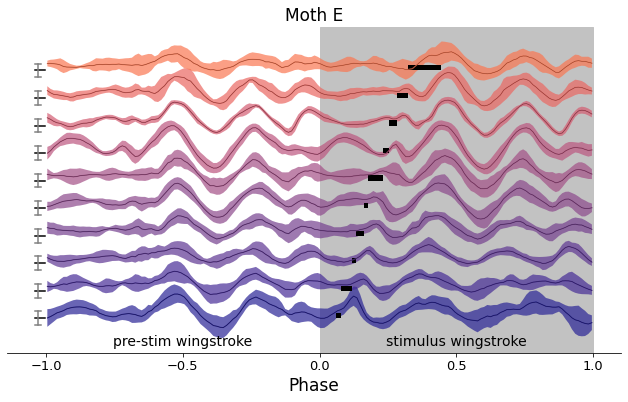

In [12]:
backShadeColor = '#C2C2C2'
saveDates = ['20210817_1', '20210819'] # Chosen dates to make finalized version of plots for
usewb = (-1, 2) # ignore all wingbeat except in this range
ngridx = 252 # How many samples in x axis to take mean+std along
lenwb = int(ngridx/3)
sep = 4 # amount to separate mean traces by 
rech, recoff = 0.75, 0 # Phase indicator rectangle height and offset
ndec = 10 # How many "deciles"? (decile implies 10, but I'm sticking with the term anyways)
cmap = cmr.get_sub_cmap('cmr.torch', 0.2, 0.7) # colormap

figwaves, axwaves = plt.subplots(len(runDates), 1, figsize=(6,15), sharex=True, sharey=True)
figdif, axdif = plt.subplots(len(runDates), 1, figsize=(6,15), sharex=True, sharey=True)
# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimfirst)].copy()
    # Zero time, trim data to region around t=0, change phase to be unique for each wb
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    dt.phase = dt.phase + dt.wb
    # Generate y axis vector
    dt['yvar'] = 0
    dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
    dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
        lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'LDLM_fsphase'].iloc[0]))
    dt = dt.loc[~np.isnan(dt.yvar)]
    # Split by deciles
    dec = np.percentile(dt.yvar, np.arange(0, 100, ndec))
    dt['dec'] = np.digitize(dt.yvar, dec)
    # Get mean waveforms for each decile
    xl,yl,gl = binPlot(dt, 'phase', ['mx'], 'dec', 'dec', ngridx+1, makeplot=False)
    # Extend decile to make plotting ranges easier
    dec = np.append(dec, np.max(dt.yvar))
    
    #---- Mean + std waveform plots
    with plt.style.context('fast'):
        plt.figure(figsize=(11,6))
    # Plot Mean + Std 
    for i in range(ndec):
        inds = slice(0, 2*lenwb)
        plt.fill_between(xl[i]['mean'][inds],
                        1 + sep*i + yl[i]['mean'][inds] - yl[i]['std'][inds],
                        1 + sep*i + yl[i]['mean'][inds] + yl[i]['std'][inds],
                        color=cmap(gl[i]/ndec),
                        alpha=0.7,
                        edgecolor='none')
        plt.plot(xl[i]['mean'][inds], 1 + sep*i + yl[i]['mean'][inds], color=cmap(gl[i]/ndec), lw=1)
        plt.plot(xl[i]['mean'][inds], 1 + sep*i + yl[i]['mean'][inds], color='k', lw=0.5, alpha=0.5)
        # Induced spike phase bars for each group
        plt.gca().add_patch(Rectangle((dec[i], sep*i-recoff), dec[i+1]-dec[i], rech, facecolor='k'))
        # Zero point/scale bar
        plt.plot([-1.04, -1.005], [sep*i, sep*i], 'k')
        plt.plot([-1.03, -1.03], [sep*i-1, sep*i+1], 'grey')
        plt.plot([-1.04, -1.02], [sep*i+1, sep*i+1], 'grey')
        plt.plot([-1.04, -1.02], [sep*i-1, sep*i-1], 'grey')
    # Label each wingbeat
    plt.text(-0.5, -sep, 'pre-stim wingstroke', fontsize=14, horizontalalignment='center')
    plt.text(0.5, -sep, 'stimulus wingstroke', fontsize=14, horizontalalignment='center')
    # plt.text(1.5, -sep, 'post-stim wingstroke', fontsize=14, horizontalalignment='center')
    plt.axvspan(xmin=0, xmax=1, color=backShadeColor, zorder=0)
    ax = plt.gca()
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks(np.arange(-1, 1.5, 0.5))
    plt.xlabel('Phase', fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=13)
    plt.title('Moth ' + mothNameDict[d], fontsize=17)
    if d in saveDates:
        plt.savefig(paperpicsdir + 'stim_methods_meanstd_moth' + mothNameDict[d] + '.pdf')
    
    #---- Just mean waveforms for all moths
    closesep = 2
    for i in range(ndec):
        # Regular mean waves
        axwaves[di].plot(xl[i]['mean'][lenwb:2*lenwb],
                closesep*i + np.array(yl[i]['mean'][lenwb:2*lenwb]),
                color=cmap(i/ndec))
        axwaves[di].add_patch(Rectangle((dec[i], closesep*i), dec[i+1]-dec[i], rech, facecolor='k'))
        axwaves[di].plot([0,1], [closesep*i,closesep*i], color='grey', alpha=0.5, lw=0.75, zorder=3)
        # Pre stim - stim waves
        axdif[di].plot(xl[i]['mean'][lenwb:2*lenwb],
                closesep*i + np.array(yl[i]['mean'][0:lenwb]) - np.array(yl[i]['mean'][lenwb:2*lenwb]),
                color=cmap(i/ndec))
        axdif[di].add_patch(Rectangle((dec[i], closesep*i), dec[i+1]-dec[i], rech, facecolor='k'))
        axdif[di].plot([0,1], [closesep*i,closesep*i], color='grey', alpha=0.5, lw=0.75, zorder=3)
    axwaves[di].text(-0.1, 12, 'Moth ' + mothNameDict[d], rotation='vertical', fontsize=17)
    axwaves[di].spines['left'].set_visible(False)
    axwaves[di].spines['right'].set_visible(False)
    axwaves[di].spines['top'].set_visible(False)
    axwaves[di].set_yticks([])
    axwaves[di].set_xticks(np.arange(0, 1.1, 0.25))
    axwaves[di].add_patch(Rectangle((-0.06,-0.04), 0.003, 4, color='grey'))
    axdif[di].text(-0.1, 12, 'Moth ' + mothNameDict[d], rotation='vertical', fontsize=17)
    axdif[di].spines['left'].set_visible(False)
    axdif[di].spines['right'].set_visible(False)
    axdif[di].spines['top'].set_visible(False)
    axdif[di].set_yticks([])
    axdif[di].set_xticks(np.arange(0, 1.1, 0.25))
    axdif[di].add_patch(Rectangle((-0.04,-0.02), 0.003, 4, color='grey'))

figwaves.subplots_adjust(hspace=0.0, wspace=0.0)
axwaves[-1].set_xlabel('Phase', fontsize=17)
axwaves[-1].tick_params(axis='x', which='major', labelsize=13)
figwaves.savefig(paperpicsdir + 'stim_qualitative_waves.pdf')
figdif.subplots_adjust(hspace=0.0, wspace=0.0)
axdif[-1].set_xlabel('Phase', fontsize=17)
axdif[-1].tick_params(axis='x', which='major', labelsize=13)
figdif.savefig(paperpicsdir + 'stim_qualitative_waves_dif.pdf')




# PCA on Deciles

- Treat individual as a column/variable of the data, do a unified approach


processing 20210803_1
processing 20210816_1
processing 20210817_1
processing 20210818_1
processing 20210819


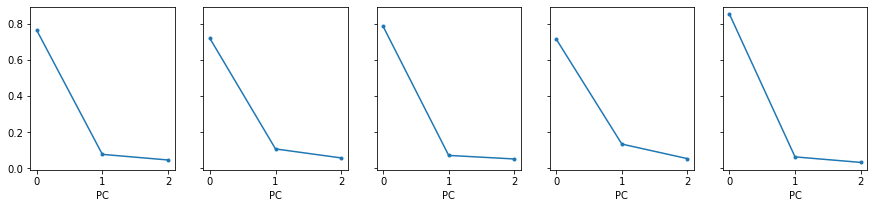

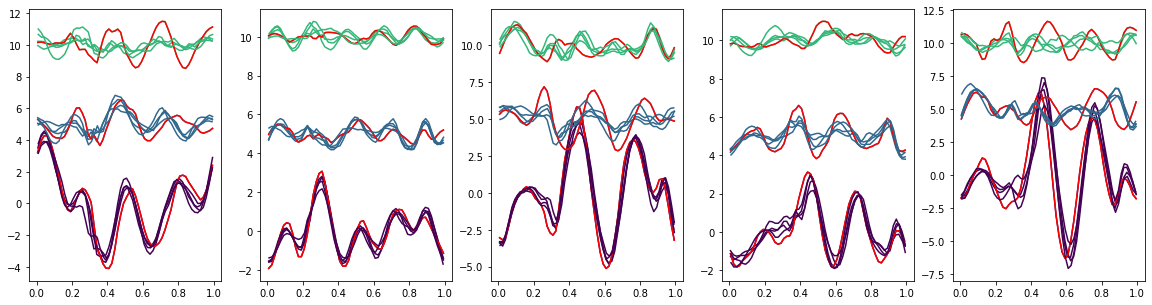

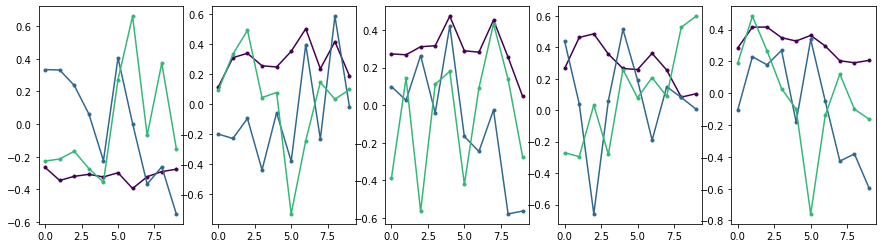

In [8]:
usewb = (-2, 3) # ignore all wingbeat except in this range
usewindow = (-200, 200) # ms, window to actually observe around zero'd time
ncomp = 3
ngridx = 300

figev, axev = plt.subplots(1, len(runDates), figsize=(15,3), sharey=True) # explained variance figure
figpc, axpc = plt.subplots(1, len(runDates), figsize=(20,5)) # Main PC traces
figload, axload = plt.subplots(1, len(runDates), figsize=(15,4)) # PC loadings
viridis = cmx.get_cmap('viridis')

# Loop over dates
for di,d in enumerate(runDates):
    print('processing ' + d)
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimfirst)].copy()
    # Zero time, trim data to region around t=0, change phase to be unique for each wb
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    dt = dt.loc[(dt.Time>=usewindow[0]/1000) & (dt.Time<=usewindow[1]/1000)]
    dt.phase = dt.phase + dt.wb
    # Generate y axis vector
    dt['yvar'] = 0
    dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
    dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
        # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'td'].iloc[0])
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim']))
    dt = dt.loc[~np.isnan(dt.yvar)]
    
    # Split by deciles
    dec = np.percentile(dt.yvar, np.arange(0, 100, 10))
    dt['dec'] = np.digitize(dt.yvar, dec)
    # Get mean waveforms for each decile
    xl,yl,gl = binPlot(dt, 'phase', ['mx'], 'dec', 'dec', ngridx+1, makeplot=False)
    
    # Put into PCA matrix
    mat = np.vstack([yl[i]['mean'] for i in range(len(yl))]).T
    # Run PCA
    pca = PCA(n_components=ncomp)
    pc = pca.fit_transform(mat)
    
    # Plot PCA explained variance
    axev[di].plot(pca.explained_variance_ratio_, '.-')
    axev[di].set_xlabel('PC')
    # Plot main PC's
    # for i in range(ncomp):
    #     axpc[di].plot(xl[i]['mean'], pc[:,i]+i*5, color=viridis(i/pc.shape[1]))
    for i in range(ncomp):
        for j in np.arange(usewb[0],usewb[1]):
            inds = (xl[i]['mean']<(j+1)) & (xl[i]['mean']>j)
            axpc[di].plot(xl[i]['mean'][inds]-j, pc[inds,i]+i*5, color=viridis(i/pc.shape[1]))
            if j==0:
                axpc[di].plot(xl[i]['mean'][inds]-j, pc[inds,i]+i*5, color='red')
    # Plot loadings of each PC against decile
    for i in range(ncomp):
        axload[di].plot(np.arange(len(xl)), pca.components_[i,:], '.-', color=viridis(i/ncomp))

# CCA Data Setup

In [3]:
phaseOrTime = 'phase'
usewb = (0,1)
phaseSamples = 300 # total samples to interpolate for phase
timeWindow = (0,500) # samples (before t=0, after t=0)

# make dataframe subset
dt = df.loc[(df.wb>=-2) & 
            (df.wb<=3) & 
            (df.stimfirst)].copy()
# Zero time, trim data to region around t=0
dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
    # lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
# Filtering
dt.phase = dt.wb + dt.phase # set phase to continuously increase
# Remove any pulses that lack the full wingbeat range
if phaseOrTime=='phase':
    dt = dt.loc[(dt.wb>=usewb[0]) & (dt.wb<=usewb[1])]
    dt = dt.groupby(['date','pulse']).filter(lambda g: (g.wb.iloc[0]==usewb[0]) & (g.wb.iloc[-1]==usewb[1]))
else:
    dt = dt.groupby(['date','pulse']).filter(lambda g: np.sum((g.Time>=timeWindow[0]/fsamp) & (g.Time<=timeWindow[1]/fsamp)) >= timeWindow[1])

# Create grouped df
dtgroup = dt.groupby(['date','pulse'])
# Prep by getting dimensions of matrices (how many observations)
n = len(dtgroup.groups.keys())

# Generate X
if phaseOrTime=='time': # Use Time as X, pass a simple window
    X = np.zeros((n,sum(timeWindow)))
    timevec = np.linspace(0, 1000*timeWindow[1]/fsamp, timeWindow[1])
    for i, (name, g) in enumerate(dtgroup):
        index0 = (g.Time==0).idxmax()
        X[i,:] = g.loc[(index0-timeWindow[0]):(index0+timeWindow[1]-1), 'mx']
else: # Use phase as X, forced to interpolate
    X = np.zeros((n,phaseSamples))
    timevec = np.linspace(usewb[0], usewb[1], phaseSamples)
    for i, (name, g) in enumerate(dtgroup):
        interpfunc = interp1d(g.phase, g['mx'], kind='linear')
        X[i,:] = interpfunc(timevec)
# Generate Y
def aggfunc(g):
    x = [g.loc[g.wb==0,'LDLM_fsphase'].iloc[0]]
    return x
Y = np.vstack(dtgroup.apply(aggfunc).reset_index()[0].to_numpy())

dateRows = np.ravel(dtgroup.aggregate({'date':'first'}).to_numpy())

# Get actual length of each pulse/observation (in samples)
lenActual = dtgroup.apply(lambda g: len(g)).reset_index()[0].to_numpy()

In [7]:
np.random.shuffle(Y)

# Regularized Kernel CCA
Done using the pyrcca package

In [12]:
import rcca

# Create a cca object as an instantiation of the CCA object class. 
cca = rcca.CCA(kernelcca = False, reg = 0., numCC = 2)
# Use the train() method to find a CCA mapping between the two training sets.
cca.train([X, Y])

# CCA 

In [11]:
nsamples, ncomp = Y.shape
Iyy = 266.7*1e-09 # gmm^2 to kg m^2
with plt.style.context('fast'):
    cmap = cmr.get_sub_cmap('cmr.torch', 0.2, 0.9) # colormap
    figScore, axScore = plt.subplots(len(runDates), ncomp, figsize=(3*ncomp,7)) # feature scores against each variable
    figFeat, axFeat = plt.subplots(len(runDates), 3, figsize=(18,12), sharex=True, sharey='row') # recreate waveforms with features
    figVar, axVar = plt.subplots(len(runDates), 3, figsize=(9,7), sharex='col')
    figLastVal, axLastVal = plt.subplots(len(runDates), 1, figsize=(4,10), sharex=True)
    figAngle, axAngle = plt.subplots(len(runDates), 1, figsize=(3,10), sharex=True)
    figVel, axVel = plt.subplots(len(runDates), 1, figsize=(3,10), sharex=True)
    figExpVar = plt.figure(figsize=(4,10.5))
    axExpVar = figExpVar.add_subplot()

allcca, varexplained = [], []
# Loop over dates
for di, d in enumerate(runDates):
    # Get values for this individual
    thisX, thisY = X[dateRows==d,:], Y[dateRows==d,:]
    # Normalize X and Y
    xmeans, ymeans = np.mean(thisX, axis=0), np.mean(thisY, axis=0)
    # xstd, ystd = thisX.std(), thisY.std(axis=0, ddof=1) 
    xstd, ystd = thisX.std(), thisY.std()
    # In Joy's data they did not divide bty standard deviation in each column
    thisX = (thisX - xmeans) / xstd
    thisY = (thisY - ymeans) / ystd
    Xtrain, Ytrain = thisX, thisY
    ntrain = Xtrain.shape[0] # How many wingbeats for this individual
    # Deciles of stim timing
    dec = np.digitize(thisY, np.percentile(thisY, np.arange(0,100,10)))
    
    # Fit CCA!
    cca = CCA(n_components=ncomp, scale=False)
    cca.fit(Xtrain, Ytrain)
    allcca.append(cca)
    
    # Transform X and Y back (_t is in normalized space, otherwise in regular units space)
    Xtrain_t, Ytrain_t = Xtrain, Ytrain
    Xtrain = Xtrain * xstd + xmeans
    Ytrain = Ytrain * ystd + ymeans
    # Obtain xscores
    xscores = cca.transform(Xtrain_t)
    
    #--- PLOTS
    # Plot x scores for each output variable against values of that variable
    for i in range(cca.n_components):
        axScore[di].plot(Ytrain_t[:,i], xscores[:,i], '.', color=cmap(i/ncomp))
    axScore[di].set_ylabel(d + "\n""Scores")
    # Plot scored features, original waveforms, and error between the two
    feats = (xscores @ cca.x_loadings_.T) * xstd + xmeans
    wave_orig = Xtrain
    wave_resid = wave_orig - feats
    mincol, maxcol = 0, 0.55 # Fixed color range across individuals
    # mincol, maxcol = 0, 1.0 # Fixed color range across individuals
    for i in range(Xtrain.shape[0]):
        thiscol = cmap((Ytrain[i,0]-mincol)/(maxcol-mincol))
        axFeat[di,0].plot(timevec, wave_orig[i,:], color=thiscol, alpha=0.5)
        axFeat[di,1].plot(timevec, feats[i,:], color=thiscol, alpha=0.5)
        axFeat[di,2].plot(timevec, wave_resid[i,:], color=thiscol, alpha=0.5)
        axFeat[di,0].get_yaxis().set_ticks([-2.5,0,2.5])
    axFeat[di,0].set_ylabel('Moth ' + mothNameDict[d], fontsize=14)
    
    # How well features describe original waveforms (correlation) or (RMS residual / RMS of original waveform)
    RMS = np.sqrt(np.mean(wave_resid**2, axis=1)) / np.sqrt(np.mean(wave_orig**2,axis=1))
    corr = np.hstack([np.corrcoef(wave_orig,feats)[i,feats.shape[0]+i] for i in range(feats.shape[0])])
    unexplained_var = 1 - corr**2
    axVar[di,0].hist(RMS, bins=25, density=True, color='#8FAADC')
    axVar[di,1].hist(corr, bins=25, density=True, color='#8FAADC')
    axVar[di,2].hist(unexplained_var, bins=25, density=True, color='#8FAADC')
    axVar[di,0].axvline(1, color='white')
    
    # Column of just variance explained
    r = np.corrcoef(wave_orig.flatten(), feats.flatten())[0,1]
    varexplained.append(r**2)
    axExpVar.barh(len(runDates) - di, r**2,
                  height=0.4, align='center',
                  color='#3165AF')
    axExpVar.barh(len(runDates) - di, 1 - r**2,
                  height=0.4, left=r**2, align='center',
                  color='#AFAFAF')
    axExpVar.plot([r**2, r**2], [len(runDates)-di-0.2, len(runDates)-di+0.2], 'k')
    
    # Momentum imparted by features
    finalangle = np.zeros(Ytrain.shape)
    finalvel = np.zeros(Ytrain.shape)
    orig_momentum, feat_momentum, unex_momentum = np.zeros(Ytrain.shape), np.zeros(Ytrain.shape), np.zeros(Ytrain.shape)
    for i in range(Xtrain.shape[0]):
        finalangle[i] = np.trapz(cumtrapz(resample(feats[i,:], lenActual[i])/1000/Iyy, dx=1/fsamp), dx=1/fsamp)*180/np.pi
        finalvel[i] = np.trapz(resample(feats[i,:], lenActual[i])/1000/Iyy, dx=1/fsamp)*180/np.pi
        orig_momentum[i] = np.trapz(resample(Xtrain[i,:], lenActual[i]), dx=1/fsamp)
        feat_momentum[i] = np.trapz(resample(feats[i,:], lenActual[i]), dx=1/fsamp)
        unex_momentum[i] = np.trapz(resample(Xtrain[i,:] - feats[i,:], lenActual[i]), dx=1/fsamp)
    axLastVal[di].plot(Ytrain, feat_momentum, '.', label='CCA feat.', zorder=3)
    axLastVal[di].plot(Ytrain, orig_momentum, '^', label='Total')
    axLastVal[di].text(0.8, 0.1, 'Moth '+mothNameDict[d],
                       horizontalalignment='center', verticalalignment='center', transform=axLastVal[di].transAxes,
                       fontsize=13)
    axAngle[di].plot(Ytrain, finalangle, '.')
    axAngle[di].text(0.8, 0.1, 'Moth '+mothNameDict[d],
                    horizontalalignment='center', verticalalignment='center', transform=axAngle[di].transAxes,
                    fontsize=13)
    axVel[di].plot(Ytrain, finalvel, '.')
    # axVel[di].plot(Ytrain, finalvelall, '^', label='Total')
    axVel[di].text(0.8, 0.1, 'Moth '+mothNameDict[d],
                    horizontalalignment='center', verticalalignment='center', transform=axVel[di].transAxes,
                    fontsize=13)
    # Add to dataframe to output for testing in R
    if di==0: 
        outputdf = pd.DataFrame({
            'induced_phase' : Ytrain.reshape(-1),
            'Moth' : np.repeat(mothNameDict[d], len(Ytrain)),
            'feat_impulse' : feat_momentum.reshape(-1),
            'total_impulse' : orig_momentum.reshape(-1)
        })
    else:
        outputdf = pd.concat(
            [outputdf,
            pd.DataFrame({
                'induced_phase' : Ytrain.reshape(-1),
                'Moth' : np.repeat(mothNameDict[d], len(Ytrain)),
                'feat_impulse' : feat_momentum.reshape(-1),
                'total_impulse' : orig_momentum.reshape(-1)
            })]
        )

# Various other figure labels
metricNames = ['Residual RMS/Original RMS \n (<1 is improvement)', 'R of features on original', 'Unexplained Variance']
# Feature reconstruction labels
axFeat[0,0].set_title('Actual data', fontsize=14)
axFeat[0,1].set_title('CCA feature reconstruction', fontsize=14)
axFeat[0,2].set_title('Data w/ features removed', fontsize=14)
for i in range(3):
    axVar[len(runDates)-1,i].set_xlabel(metricNames[i])
    for j in range(len(runDates)):
        axFeat[j,i].tick_params(labelsize=14)

axExpVar.spines['left'].set_visible(False)
axExpVar.spines['right'].set_visible(False)
axExpVar.spines['top'].set_visible(False)
axExpVar.set_yticks([len(runDates) - i for i in range(len(runDates))])
axExpVar.set_yticklabels([mothNameDict[d] for d in runDates], fontsize=13)
axExpVar.set_xlabel('Proportion of total variance', fontsize=15)

axFeat[len(runDates)-1,0].set_xlabel('Phase', fontsize=18)
axFeat[len(runDates)-1,1].set_xlabel('Phase', fontsize=18)
axFeat[len(runDates)-1,2].set_xlabel('Phase', fontsize=18)
figFeat.subplots_adjust(hspace=0.03, wspace=0.08)
figFeat.text(0.05, 0.5, 'Pitch Torque (mNm)', va='center', rotation='vertical', color='black', fontsize=18)
figFeat.align_ylabels()
# colorbar
figFeat.subplots_adjust(right=0.95)
cbar_ax = figFeat.add_axes([0.965, 0.15, 0.01, 0.7])
cbar = figFeat.colorbar(cmx.ScalarMappable(norm=None, cmap=cmap),
                        ticks=np.arange(0,0.6,0.1)/maxcol,
                        cax=cbar_ax)
cbar.ax.set_yticklabels([str(round(x,2)) for x in np.arange(0,0.6,0.1)], fontsize=14)
cbar.ax.set_title('Induced \n DLM \n Phase', fontsize=14)

# figLastVal.text(0.5, 0.01, 'Induced DLM Phase', ha='center', fontsize=14)
figLastVal.subplots_adjust(left=0.2, right=0.9, bottom=0.05, hspace=0.02)
figLastVal.text(0.01, 0.5, 'Angular impulse (N*mm*s)', va='center', rotation='vertical', color='black', fontsize=15)
handles = [
    mlines.Line2D([],[], linestyle='', marker='.', color='#1f77b4', label='CCA feat.'),
    mlines.Line2D([],[], linestyle='', marker='^', color='#ff7f0e', label='Total')
]
figLastVal.legend(handles, ['CCA feat.', 'Total'], loc='center right', fontsize=11)
for i in range(len(runDates)):
    axLastVal[i].tick_params(axis='both', labelsize=12)
    axAngle[i].tick_params(axis='both', labelsize=12)
figAngle.subplots_adjust(left=0.24, bottom=0.05, hspace=0.02)
figAngle.text(0.01, 0.5, r'Pitch angle change $\Delta \theta$ from CCA features ($\degree$)',
              va='center', rotation='vertical', color='black', fontsize=15)
figVel.subplots_adjust(left=0.24, bottom=0.05, hspace=0.02)
figVel.text(0.01, 0.5, r'Pitch angular velocity change $\Delta \omega$ from CCA features ($\degree$/s)',
              va='center', rotation='vertical', color='black', fontsize=15)

# Save
figFeat.savefig(prespicsdir+'CCAFeatures.png', dpi=300)
figVar.savefig(prespicsdir+'CCAdescriptionPerformance.png', dpi=300)
figFeat.savefig(paperpicsdir+'CCAFeatures.pdf')
figExpVar.savefig(paperpicsdir+'CCAvarianceExplained.pdf')
figLastVal.savefig(paperpicsdir+'CCA_angular_impulse.pdf')
figAngle.savefig(paperpicsdir+'CCA_angle_change.pdf')
figVel.savefig(paperpicsdir+'CCA_velocity_change.pdf')
outputdf.to_csv(os.path.join(startdir, 'preprocessedCache', 'impulse') + '.csv')
print(f'Unexplained variance across individuals is '
      f'{np.round(np.mean(1-np.array(varexplained)), 3)} p/m '
      f'{np.round(np.std(1-np.array(varexplained)), 3)}')

/var/folders/n0/lt0cwffx32q0b723pxgmg_nh0000gp/T/ipykernel_615/26193406.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figExpVar = plt.figure(figsize=(4,10.5))


Unexplained variance across individuals is 0.7 p/m 0.068


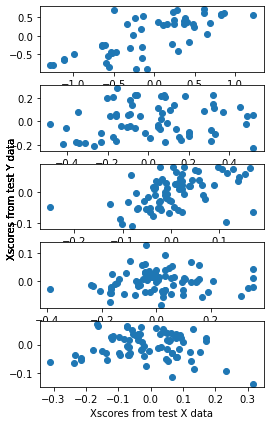

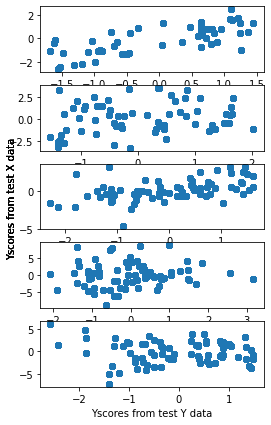

In [14]:
# Leave-one-out cross validation
fig1, ax1 = plt.subplots(len(runDates), 2, figsize=(7,7), sharex=True)
fig2, ax2 = plt.subplots(len(runDates), 1, figsize=(4,7), sharex=True)
fig3, ax3 = plt.subplots(len(runDates), 1, figsize=(4,7), sharex=True)
fig4, ax4 = plt.subplots(len(runDates), 1, figsize=(4,7))
figY, axY = plt.subplots(len(runDates), 1, figsize=(4,7))
with plt.style.context('fast'):
    figExpVar = plt.figure(figsize=(4,10.5))
    axExpVar = figExpVar.add_subplot()

# Loop over dates
for di, d in enumerate(runDates):
    # Get values for this individual
    thisX, thisY = X[dateRows==d,:], Y[dateRows==d,:]
    # Normalize X and Y
    xmeans, ymeans = np.mean(thisX, axis=0), np.mean(thisY, axis=0)
    xstd, ystd = thisX.std(), thisY.std(axis=0, ddof=1) 
    thisX = (thisX - xmeans) / xstd
    thisY = (thisY - ymeans) / ystd
    # preallocate
    method1 = np.zeros(thisX.shape[0])
    xscore_fromy = np.zeros(thisX.shape[0])
    xscore_fromx = np.zeros(thisX.shape[0])
    method2 = np.zeros(thisX.shape[0])
    feature_fromy = np.zeros(thisX.shape)
    yscore_fromy = np.zeros(thisX.shape)
    yscore_fromx = np.zeros(thisX.shape)
    coef = []
    corr = []
    # Loop over wingstrokes
    for i in range(thisX.shape[0]):
        # Leave this wingstroke out, perform CCA, and predict pitch torque of that wingstroke
        # Grab wingstrokes, fit cca
        Xtrain, Xtest = thisX[np.arange(len(thisX))!=i,:], thisX[i,:]
        Ytrain, Ytest = thisY[np.arange(len(thisY))!=i,:], thisY[i,:]
        cca = CCA(n_components=ncomp, scale=False)
        cca.fit(Xtrain, Ytrain)
        # Get y_scores<->x_scores linear model coefficients 
        A = np.vstack([cca.transform(Xtrain).reshape(-1), np.ones(Xtrain.shape[0])]).T
        coef.append(np.linalg.lstsq(A, Ytrain @ cca.y_rotations_, rcond=None)[0])
        # Double Check Model performance within training set
        feats = (cca.transform(Xtrain) @ cca.x_loadings_.T) * xstd + xmeans
        corr.append(
            np.corrcoef((Xtrain * xstd + xmeans).reshape(1,len(Xtrain)*phaseSamples),
            feats.reshape(1,len(Xtrain)*phaseSamples))[0,1]**2 
            )
        # Predict xscore given yscore for test wingstroke, create pitch torque prediction from feature using that
        xscore_fromy[i] = ((Ytest @ cca.y_rotations_) - coef[i][1]) / coef[i][0]
        # xscore_fromx[i] = cca.predict(Xtest.reshape(1,-1))
        xscore_fromx[i] = Xtest @ cca.x_rotations_
        feature_fromy[i,:] = xscore_fromy[i] * cca.x_loadings_.T * xstd + xmeans
        yscore_fromy[i] = (Ytest @ cca.y_rotations_)
        yscore_fromx[i] = Xtest @ cca.x_rotations_ * coef[i][0] + coef[i][1]
        # Method 1: r^2 for each leave-out, look at distribution of those r^2
        method1[i] = 1 - np.corrcoef(Xtest * xstd + xmeans, feature_fromy[i,:].flatten())[0,1]**2
        method2[i] = 1 - np.corrcoef(Xtest * xstd + xmeans, ((xscore_fromx[i] * cca.x_loadings_.T) * xstd + xmeans).flatten())[0,1]**2
    # Plots
    ax1[di,0].hist(method1, bins=20)
    ax1[di,1].hist(method2, bins=20)
    ax2[di].hist(corr, bins=20)
    r2 = np.mean(corr)
    axExpVar.barh(len(runDates) - di, r2,
                    height=0.4, align='center',
                    color='#3165AF')
    axExpVar.barh(len(runDates) - di, 1 - r2,
                    height=0.4, left=r2, align='center',
                    color='#AFAFAF')
    axExpVar.plot([r2, r2], [len(runDates)-di-0.2, len(runDates)-di+0.2], 'k')
    (counts, bins) = np.histogram(corr, bins=20, density=True)
    plt.hist(bins[:-1], bins, weights=0.005*counts, bottom=len(runDates)-di-0.2)
    # axExpVar.hist(corr, bins=20, bottom=len(runDates)-di-0.2)
    
    thisY = thisY * ystd + ymeans
    for i in range(thisX.shape[0]):
        thiscol = cmap((thisY[i,0]-mincol)/(maxcol-mincol))
        ax3[di].plot(timevec, feature_fromy[i,:], color=thiscol)
    ax4[di].scatter(xscore_fromx, xscore_fromy)
    axY[di].scatter(yscore_fromy, yscore_fromx)
    # Labels
    ax1[di,0].set_ylabel('Moth ' + mothNameDict[d])
    ax1[-1,0].set_xlabel('Unex. Var. (Feature from Y)')
    ax1[-1,1].set_xlabel('Unex. Var. (Feature from X)')
    ax3[di].set_ylabel('Moth ' + mothNameDict[d])
    ax4[-1].set_xlabel('Xscores from test X data')
    fig4.text(0.01, 0.5, 'Xscores from test Y data', va='center', rotation='vertical')
    axY[-1].set_xlabel('Yscores from test Y data')
    figY.text(0.01, 0.5, 'Yscores from test X data', va='center', rotation='vertical')

Note that feature means scale exactly linearly with timing variable because the only thing varying in features from observation to observation is the _scores_, which by definition have to vary linearly with timing variable. X mean and std transform are applied evenly across all, so don't alter the means, even though they do introduce the phase shift

Another key point here: If the mean of cca.x_loadings_ is negative, it will flip the direction/slope that scores will show with the means in the last plot. Otherwise the means vs. timing variable will follow the same slope the scores follow with the timing variable.

Originally thought this was due to ```svd_flip()``` in the ```_pls.py``` function, but modifying it to make all point the same way produces the same result; the resulting means and their signs just work out to make the directions stay the same

# PLS Version

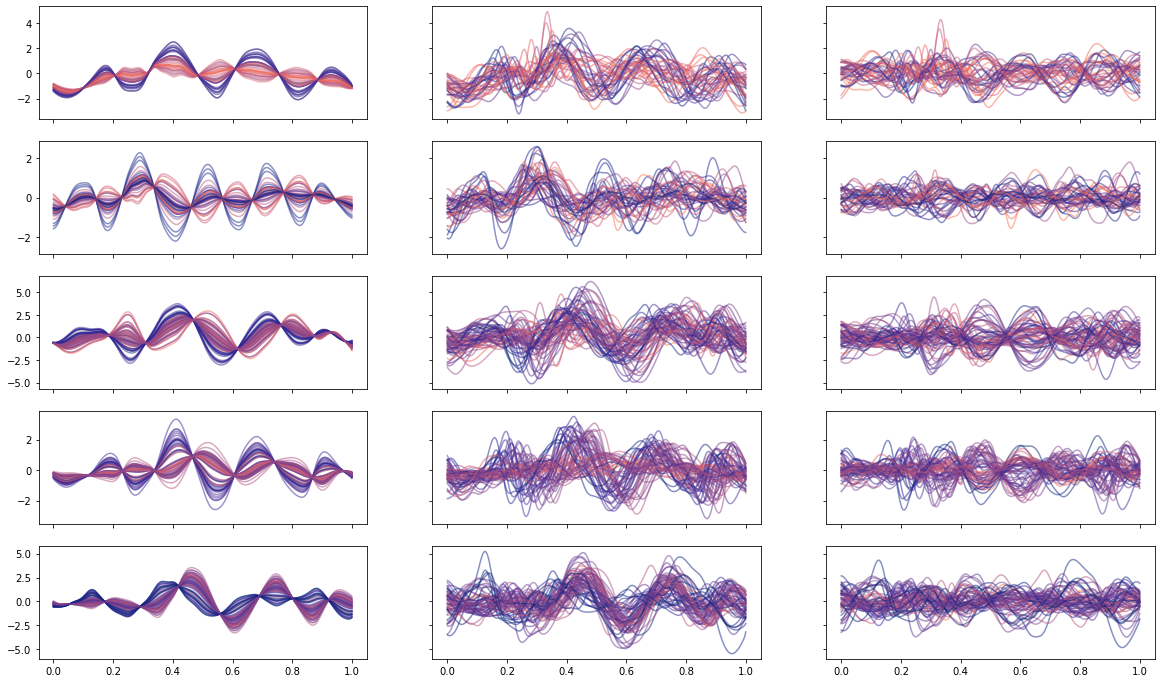

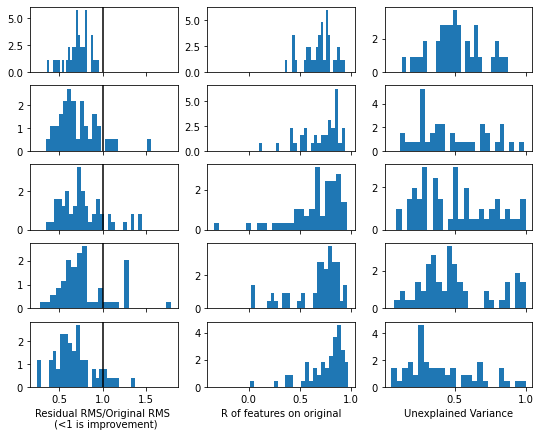

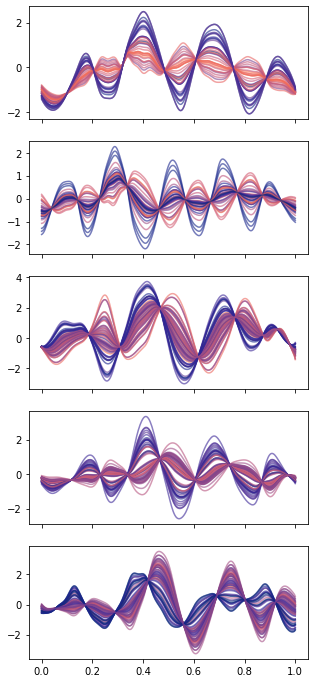

In [9]:
from sklearn.cross_decomposition import PLSRegression, PLSCanonical
nsamples, _ = Y.shape
ncomp = 1
rng = np.random.RandomState(0)

figScore, axScore = plt.subplots(len(runDates), ncomp, figsize=(3*ncomp,7)) # feature scores against each variable
figFeat, axFeat = plt.subplots(len(runDates), 3, figsize=(20,12), sharex=True, sharey='row') # recreate waveforms with features
figVar, axVar = plt.subplots(len(runDates), 3, figsize=(9,7), sharex='col')
# figExpVar, axExpVar = plt.subplots(len(runDates), ncomp, figsize=(2*ncomp,7), sharex='col')
figMean, axMean = plt.subplots(len(runDates), 2, figsize=(6,8), sharex='col', sharey='row')
figEachFeat, axEachFeat = plt.subplots(len(runDates), ncomp, figsize=(ncomp*5,12), sharex=True, sharey='row') # recreations from each component individually

allpls = []
# Loop over dates
for di, d in enumerate(runDates):
    # Get values for this individual
    thisX, thisY = X[dateRows==d,:], Y[dateRows==d,:]
    # Normalize X and Y
    xmeans, ymeans = np.mean(thisX, axis=0), np.mean(thisY, axis=0)
    xstd, ystd = thisX.std(), thisY.std(axis=0, ddof=1) 
    thisX = (thisX - xmeans)/xstd
    thisY = (thisY - ymeans)/ystd
    
    # Train and test split
    indices = np.arange(len(thisY))
    Xtrain, Xtest, Ytrain, Ytest, itrain, itest = train_test_split(thisX, thisY, indices, random_state=rng)
    # Deciles of stim timing
    dec = np.digitize(thisY, np.percentile(thisY, np.arange(0,100,10)))
    
    # Fit PLS!
    pls = PLSCanonical(n_components=ncomp, scale=False)
    pls.fit(Xtrain, Ytrain)
    allpls.append(pls)
    
    # Transform X and Y back (_t is in normalized space, otherwise in regular units space)
    Xtrain_t, Xtest_t, Ytrain_t, Ytest_t = Xtrain, Xtest, Ytrain, Ytest
    Xtrain = Xtrain * xstd + xmeans
    Xtest = Xtest * xstd + xmeans
    Ytrain = Ytrain * ystd + ymeans
    Ytest = Ytest * ystd + ymeans
    # Get xscores
    xscores = pls.transform(Xtrain_t)
    
    #--- PLOTS
    # Cross-validate with train/test split
    # axtraintest[di].plot(cca.transform(Xtest_t)[:,0], Ytest_t[:,0], 'b.', label='ground truth')
    # axtraintest[di].plot(cca.transform(Xtest_t)[:,0], cca.predict(Xtest_t)[:,0], 'r.', label='prediction')
    
    # Plot x scores for each output variable against values of that variable
    if ncomp==1:
        axScore[di].plot(Ytrain, xscores, '.', color=cmap(i/ncomp))
    else:
        for i in range(pls.n_components):
            axScore[di,i].plot(Ytrain, xscores[:,i], '.', color=cmap(i/ncomp))
    
    # Plot scored features, original waveforms, and error between the two
    feats = (xscores @ pls.x_loadings_.T) * xstd + xmeans
    wave_orig = Xtrain
    wave_resid = wave_orig - feats
    
    # mincol, maxcol = np.min(xscores), np.max(xscores) # color by score
    mincol, maxcol = np.min(Ytrain), np.max(Ytrain) #color by timing variable
    for i in range(Xtrain.shape[0]):
        # thiscol = cmap((xscores[i]-mincol)/(maxcol-mincol)) # color by score
        thiscol = cmap((Ytrain[i,0]-mincol)/(maxcol-mincol)) # color by timing variable
        axFeat[di,0].plot(timevec, feats[i,:], color=thiscol, alpha=0.5)
        axFeat[di,1].plot(timevec, wave_orig[i,:], color=thiscol, alpha=0.5)
        axFeat[di,2].plot(timevec, wave_resid[i,:], color=thiscol, alpha=0.5)
    
    # How well features describe original waveforms (correlation) or (RMS residual / RMS of original waveform)
    RMS = np.sqrt(np.mean(wave_resid**2, axis=1)) / np.sqrt(np.mean(wave_orig**2,axis=1))
    corr = np.hstack([np.corrcoef(wave_orig,feats)[i,feats.shape[0]+i] for i in range(feats.shape[0])])
    unexplainedVar = 1 - corr**2
    axVar[di,0].hist(RMS, bins=25, density=True)
    axVar[di,1].hist(corr, bins=25, density=True)
    axVar[di,2].hist(unexplainedVar, bins=25, density=True)
    axVar[di,0].axvline(1, color='black')
    
    # Variance explained by components
    for i in range(ncomp):
        compFeats = (xscores[:,[i]] @ pls.x_loadings_[:,[i]].T) * xstd + xmeans
        explainedVar = np.hstack([np.corrcoef(wave_orig,compFeats)[i,compFeats.shape[0]+i] for i in range(compFeats.shape[0])])**2
        # axExpVar[di,i].hist(explainedVar, bins=30)
        for j in range(Xtrain.shape[0]):
            thiscol = cmap((Ytrain[j,0]-mincol)/(maxcol-mincol))
            axEachFeat[di].plot(timevec, compFeats[j,:], color=thiscol, alpha=0.6)
    
    # Feature means against timing variable
    firstfeats = (xscores[:,[0]] @ pls.x_loadings_[:,[0]].T) * xstd + xmeans
    Ydecs = np.digitize(Ytrain, np.percentile(Ytrain, np.arange(0,100,10)))
    axMean[di,0].plot(Ytrain, np.mean(firstfeats,axis=1), '.')
    axMean[di,1].plot(Ydecs, np.mean(firstfeats,axis=1), '.')
    axMean[di,0].set_ylabel(d)
    

metricNames = ['Residual RMS/Original RMS \n (<1 is improvement)', 'R of features on original', 'Unexplained Variance']
for i in range(3):
    axVar[len(runDates)-1,i].set_xlabel(metricNames[i])

# Waveforms sorted by $\Delta t$: No binning/means

Text(0.5, 1.0, '$\\Delta (t_{DVM}-t_{DLM})$')

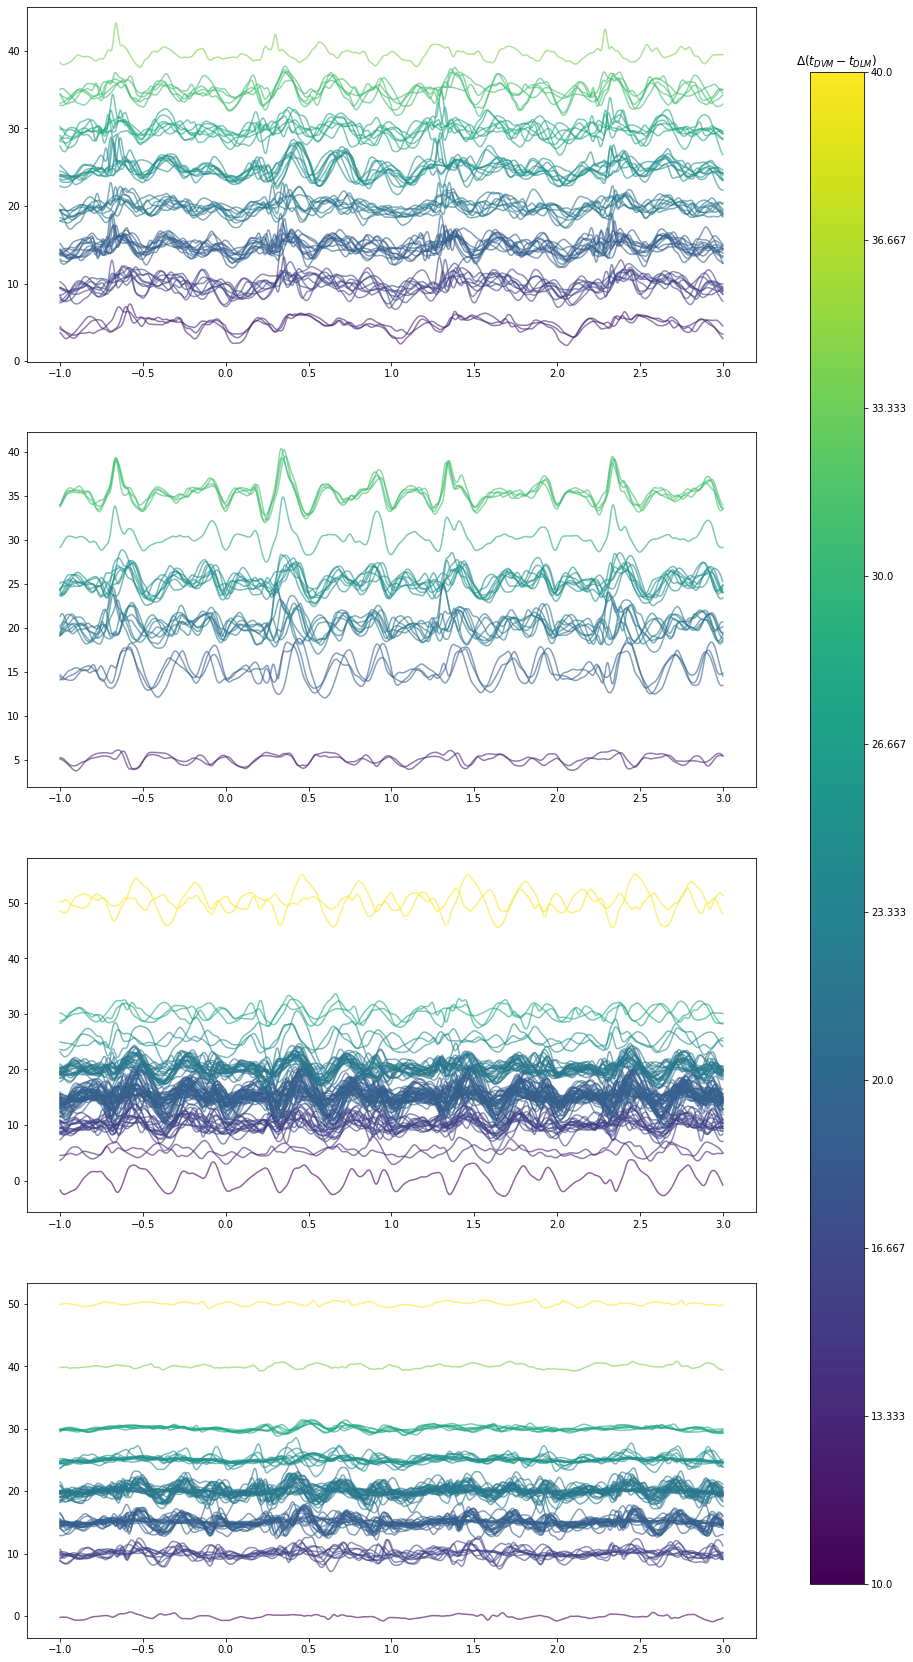

In [222]:
usewb = (-1, 3) # ignore all wingbeat except in this range
nbin = 10
# bins = np.linspace(-3, 16, nbin)
bins = np.linspace(10, 40, nbin)

fig, ax = plt.subplots(len(runDates), 1, figsize=(15,30))
viridis = cmx.get_cmap('viridis')

# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Zero time, trim data to region around t=0
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        # lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    vals = []
    # Loop over each pulse, add to matrix
    for name, g in grouped_df:
        # thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]
        thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
        vals.append(thiscol)
        thisbin = np.digitize(thiscol, bins)
        ax[di].plot(g.phase+g.wb, g.mx+5*thisbin, color=viridis(thisbin/nbin), alpha=0.6)
        # ax[di].plot(g.Time, g.mx+5*thisbin, color=viridis(thisbin/nbin), alpha=0.6)
# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
mincol, maxcol = bins[0], bins[-1]
cbar = fig.colorbar(cmx.ScalarMappable(norm=None, cmap=viridis),
                    ticks=(bins-mincol)/(maxcol-mincol),
                    cax=cbar_ax)
cbar.ax.set_yticklabels([str(round(x,3)) for x in bins])
cbar.ax.set_title(r'$\Delta (t_{DVM}-t_{DLM})$')

# $(t_{DVM}-t_{DLM})$ vs stimphase:
How well does the actual stimulus phase connect to DVM-DLM timing difference? Not important, but just curious

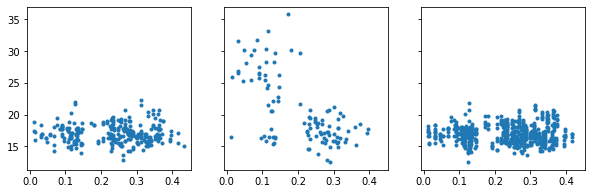

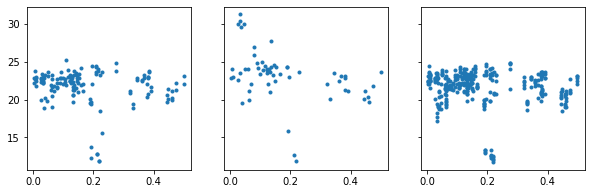

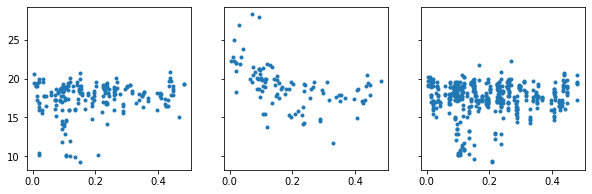

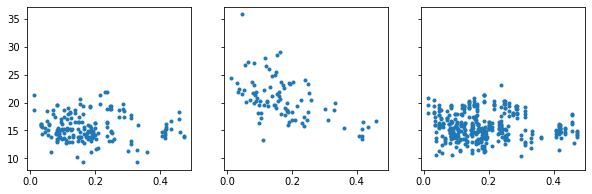

In [163]:
ncomp = 4
usewb = (-2, 6)

aggdict = {}
aggdict['wbstate'] = 'first'
aggdict['stimphase'] = 'first'
aggdict['tdl'] = 'first'
aggdict['tdr'] = 'first'

# Loop over dates
for d in runDates:
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    
    g = dt.groupby(['date','pulse','wb']).aggregate(aggdict)
    
    fig, ax = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True)
    for i,state in enumerate(['pre','stim','post']):
        dsub = g.loc[g.wbstate==state]
        ax[i].plot(dsub.stimphase, dsub.tdl, '.')

# How wingbeat period/frequency ($F_z$ cycles) is impacted by stimulation

[Text(1, 0.0, '0.0'),
 Text(1, 0.1111111111111111, '0.056'),
 Text(1, 0.2222222222222222, '0.111'),
 Text(1, 0.3333333333333333, '0.167'),
 Text(1, 0.4444444444444444, '0.222'),
 Text(1, 0.5555555555555556, '0.278'),
 Text(1, 0.6666666666666666, '0.333'),
 Text(1, 0.7777777777777777, '0.389'),
 Text(1, 0.8888888888888888, '0.444'),
 Text(1, 1.0, '0.5')]

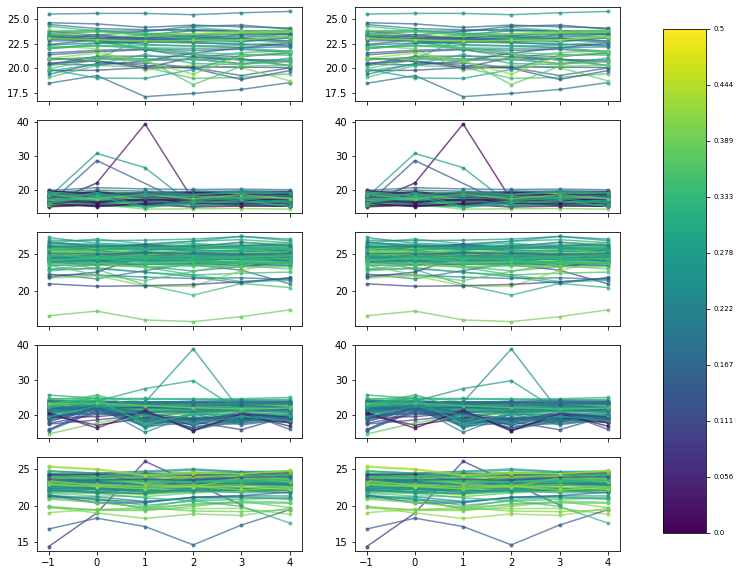

In [18]:
plt.close('all')
usewb = (-1, 5) # ignore all wingbeats except in this range
fig, ax  = plt.subplots(len(runDates), 2, sharex=True, figsize=(12,10))
# Loop over dates
for ind,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimfirst)].copy()
    # Color setup
    viridis = cmx.get_cmap('viridis')
    # maxcol, mincol = 15, -3
    maxcol, mincol = 0.5, 0
    # Zero time
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    # Loop over each pulse, add to matrix
    for name, g in dt.groupby(['date','pulse']):
        # Loop over left and right
        for lri,lr in enumerate(['L','R']):
            thiscol = g.loc[g.wbstate=='stim', lr+'DLM_fsphase'].iloc[0]
            # thiscol = g.loc[g.wbstate=='stim', 'td'+lr].iloc[0] - g.loc[g.wb==-1, 'td'+lr].iloc[0]
            # thiscol = g.loc[g.wbstate=='stim', 'tdr'].iloc[0]
            # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
            dg = g.groupby('wb').size()
            # ax[ind,lri].plot(dg.index, (dg.values-dg.values[0])/10, '.-', color=viridis((maxcol-thiscol)/(maxcol-mincol)))
            ax[ind,lri].plot(dg.index, fsamp/dg.values, '.-', alpha=0.7, color=viridis((maxcol-thiscol)/(maxcol-mincol)))
# Labels
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
tickrange = np.linspace(mincol, maxcol, 10)
cbar = fig.colorbar(cmx.ScalarMappable(norm=None, cmap=viridis),
                    ticks=(tickrange-mincol)/(maxcol-mincol),
                    cax=cbar_ax)
cbar.ax.set_yticklabels([str(round(x,3)) for x in tickrange], fontsize=7)
# cbar.ax.set_title(r'$\Delta (t_{DVM}-t_{DLM})$')

# SICB Presentation Figures

In [54]:
muscleCols = ['#66AFE6','#E87D7A','#C14434','#2A4A78']
dt = df.loc[
    (df.wb>-3) & (df.wb<2) &
    (df.date=='20210819')
]
# dt = dt.loc[dt.pulse==np.random.choice(np.unique(dt.pulse))]
dt = dt.loc[dt.pulse==99]
with plt.style.context('dark_background'):
    plt.figure(figsize=(15,4))
    for i,m in enumerate(['RDLM']):
        ymin, ymax = np.nanmin(dt[m]), np.nanmax(dt[m])
        plt.plot(dt.Time, i+(dt[m]-ymin)/(ymax-ymin), color=muscleCols[2])
    # for j in np.unique(dt['wb']):
    #     wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
    #     if j % 2 == 0:
    #         plt.axvspan(wbtime[0], wbtime[-1], lw=0, color='#C2C2C2')
    plt.axvline(x=dt.Time.iloc[np.where(np.isnan(dt.LDVM))[0][0]], color='white')
    plt.gca().axis('off')
    plt.savefig(prespicsdir+'stimulatingAP.png', dpi=300)

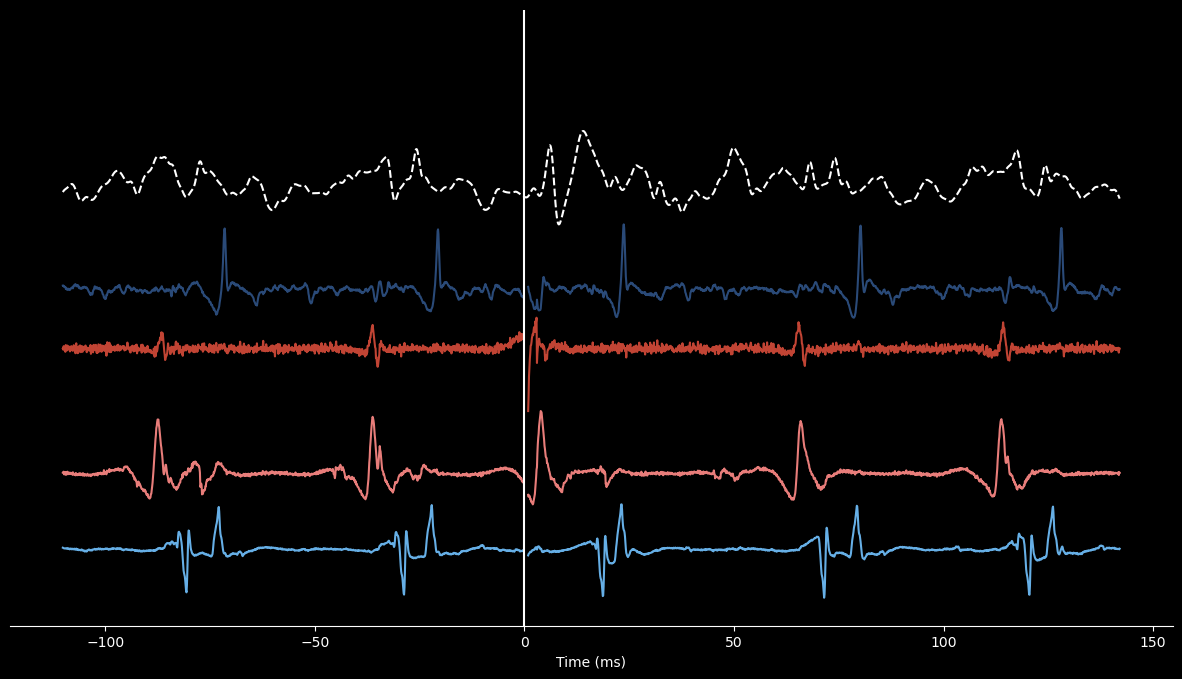

In [117]:
muscleCols = ['#66AFE6','#E87D7A','#C14434','#2A4A78']
rescale = [1,1,1.4,1]
dt = df.loc[
    (df.wb>-3) & (df.wb<3) &
    (df.date=='20210818_1')
]
# dt = dt.loc[dt.pulse==np.random.choice(np.unique(dt.pulse))]
dt = dt.loc[dt.pulse==65]
dt.Time -= dt.Time.iloc[np.argmax(dt.stim)]
dt.Time *= 1000
with plt.style.context('dark_background'):
    plt.figure(figsize=(15,8))
    # Plot EMGs
    for i,m in enumerate(channelsEMG):
        ymin, ymax = np.nanmin(dt[m]), np.nanmax(dt[m])
        plt.plot(dt.Time, i+(dt[m]-ymin)/(ymax-ymin), color=muscleCols[i])
        # plt.plot(dt.Time, i+dt[m]/rescale[i], color=muscleCols[i])
    # Plot Mx
    ymin, ymax = np.nanmin(dt.mx), np.nanmax(dt.mx)
    plt.plot(dt.Time, (dt.mx-ymin)/(ymax-ymin)+4, '--', color='white')
    ymin, ymax = np.nanmin(dt.fz), np.nanmax(dt.fz)
    plt.plot(dt.Time, (dt.fz-ymin)/(ymax-ymin)+5, '--', color='none')
    # Plot stimulus bar
    plt.axvline(x=dt.Time.iloc[np.where(np.isnan(dt.LDVM))[0][0]], color='white')
    ax = plt.gca()
    ax.get_yaxis().set_ticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Time (ms)')
    plt.savefig(prespicsdir+'examplePulse_nowb.png', dpi=300)

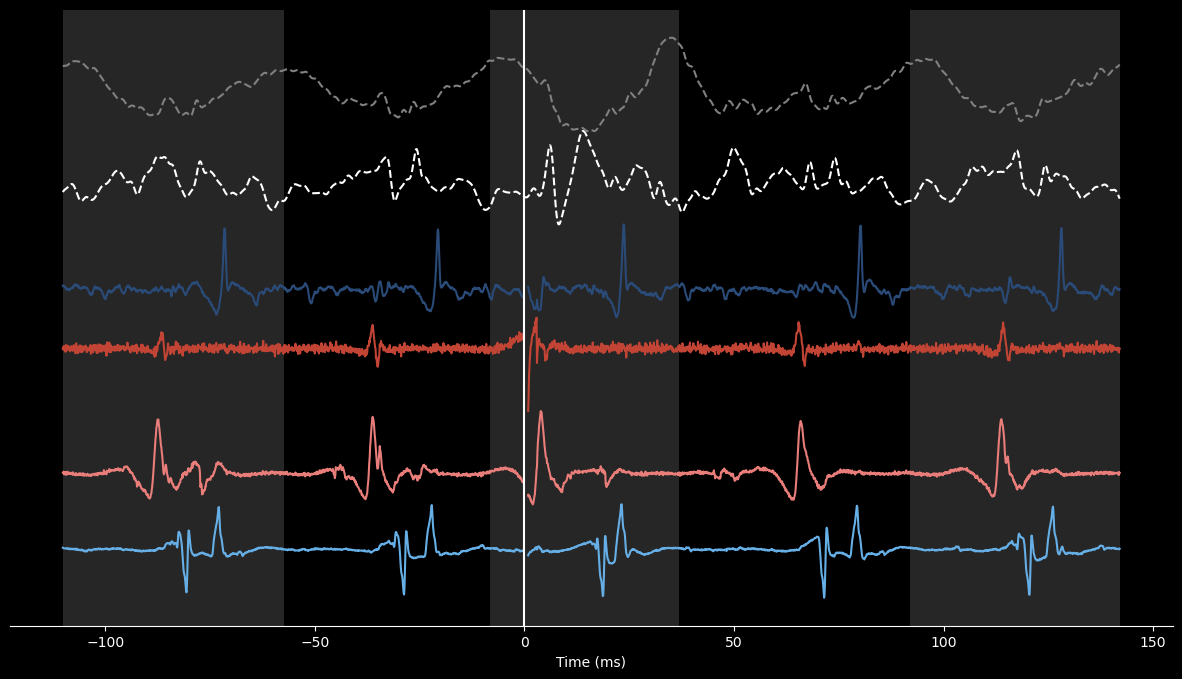

In [118]:
muscleCols = ['#66AFE6','#E87D7A','#C14434','#2A4A78']
rescale = [1,1,1.4,1]
dt = df.loc[
    (df.wb>-3) & (df.wb<3) &
    (df.date=='20210818_1')
]
# dt = dt.loc[dt.pulse==np.random.choice(np.unique(dt.pulse))]
dt = dt.loc[dt.pulse==65]
dt.Time -= dt.Time.iloc[np.argmax(dt.stim)]
dt.Time *= 1000
with plt.style.context('dark_background'):
    plt.figure(figsize=(15,8))
    # Plot EMGs
    for i,m in enumerate(channelsEMG):
        ymin, ymax = np.nanmin(dt[m]), np.nanmax(dt[m])
        plt.plot(dt.Time, i+(dt[m]-ymin)/(ymax-ymin), color=muscleCols[i])
        # plt.plot(dt.Time, i+dt[m]/rescale[i], color=muscleCols[i])
    # Plot Mx, Fz
    ymin, ymax = np.nanmin(dt.mx), np.nanmax(dt.mx)
    plt.plot(dt.Time, (dt.mx-ymin)/(ymax-ymin)+4, '--', color='white')
    ymin, ymax = np.nanmin(dt.fz), np.nanmax(dt.fz)
    plt.plot(dt.Time, (dt.fz-ymin)/(ymax-ymin)+5, '--', color='grey')
    # Plot wingbeat shading blocks, stimulus bar
    for j in np.unique(dt['wb']):
        wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
        if j % 2 == 0:
            plt.axvspan(wbtime[0], wbtime[-1], lw=0, color='#262626')
    plt.axvline(x=dt.Time.iloc[np.where(np.isnan(dt.LDVM))[0][0]], color='white')
    ax = plt.gca()
    ax.get_yaxis().set_ticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Time (ms)')
    plt.savefig(prespicsdir+'examplePulse.png', dpi=300)

/Users/leo/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


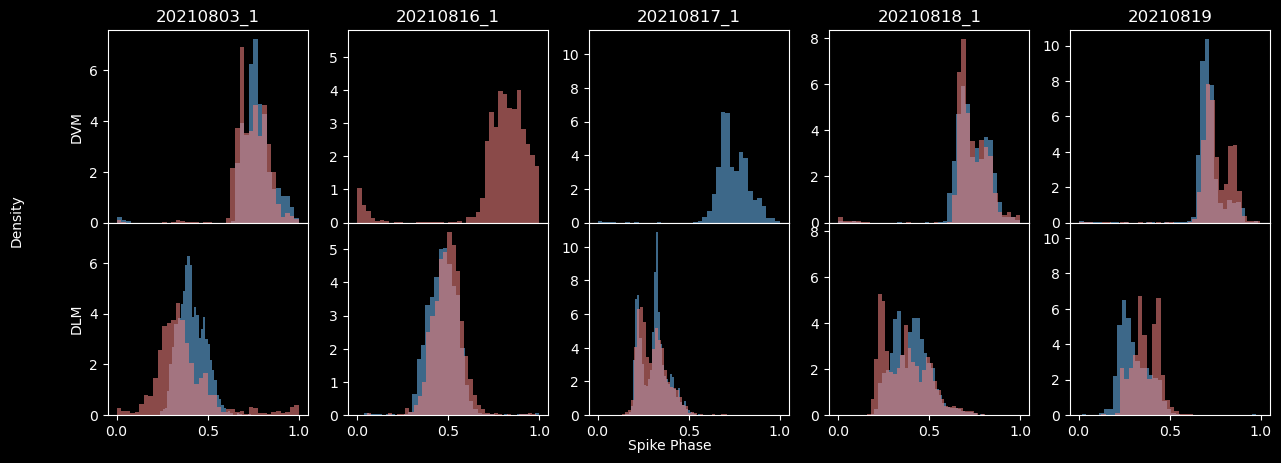

In [130]:
mcols = ['#66AFE6','#E87D7A','#C14434','#2A4A78']
alpha = 0.6
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(2,len(runDates), sharex=True, figsize=(15,5), sharey='col')
    for i,d in enumerate(runDates):
        dt = df.loc[(df.stimfirst) & (df.wb!=0) & (df.date==d)]
        ax[0,i].hist(dt.loc[dt['LDVM_st'], 'phase'], bins=40, color=mcols[0], alpha=alpha, density=True)
        ax[0,i].hist(dt.loc[dt['RDVM_st'], 'phase'], bins=40, color=mcols[1], alpha=alpha, density=True)
        ax[1,i].hist(dt.loc[dt['LDLM_st'], 'phase'], bins=40, color=mcols[0], alpha=alpha, density=True)
        ax[1,i].hist(dt.loc[dt['RDLM_st'], 'phase'], bins=40, color=mcols[1], alpha=alpha, density=True)
        ax[0,i].set_title(d)
    ax[0,0].set_ylabel('DVM')
    ax[1,0].set_ylabel('DLM')
    fig.text(0.06, 0.5, 'Density', va='center', rotation='vertical')
    fig.text(0.5, 0.04, 'Spike Phase', ha='center')
    plt.subplots_adjust(hspace=0)
    plt.savefig(prespicsdir+'spikePhaseHistograms.png', dpi=300)

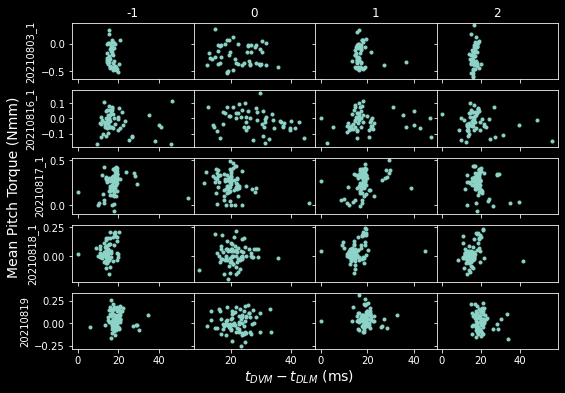

In [52]:
window = 500 #samples
usewb = [-1,2]

# plt.figure()
# axall = plt.gca()
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(len(runDates), usewb[1]+1-usewb[0], figsize=(9,6), sharex='col', sharey='row')
# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<=usewb[1]) & 
                (df.stimfirst)].copy()
    dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
    # Take means per wingbeat
    dt = dt.groupby(['date','pulse','wb']).aggregate({
        'mx' : lambda g: np.mean(g),
        'td' : 'first'
    }).reset_index()
    # Set tvar to stimulus wingbeat value for all in pulse
    dt['tvar'] = dt['td']
    # dt['tvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
    #     lambda g: g['tvar'] + g.loc[g.wb==0,'td'].to_numpy()[0])
    for ind,i in enumerate(np.arange(usewb[0], usewb[1]+1)):
        ax[di,ind].plot(dt.loc[dt.wb==i,'tvar'], dt.loc[dt.wb==i,'mx'],'.')
    ax[di,0].set_ylabel(d)
for ind,i in enumerate(np.arange(usewb[0], usewb[1]+1)):
    ax[0,ind].set_title(i)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(left=0.15)
fig.text(0.05, 0.5, 'Mean Pitch Torque (mNm)', va='center', rotation='vertical', color='white', fontsize=14)
fig.text(0.5, 0.05, r'$t_{DVM}-t_{DLM}$ (ms)', ha='center', color='white', fontsize=14)
plt.savefig(prespicsdir+'wingbeatMeans.png', dpi=300)

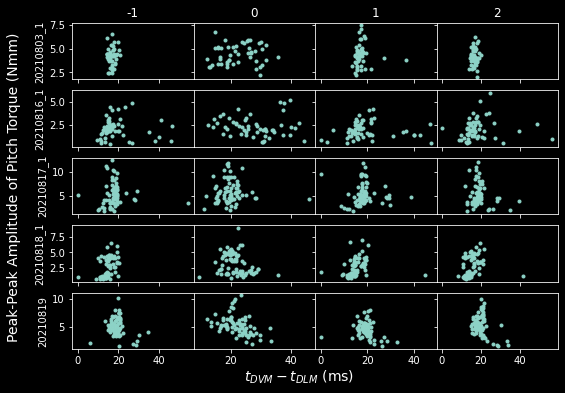

In [29]:
window = 500 #samples
usewb = [-1,2]

# plt.figure()
# axall = plt.gca()
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(len(runDates), usewb[1]+1-usewb[0], figsize=(9,6), sharex='col', sharey='row')
# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<=usewb[1]) & 
                (df.stimfirst)].copy()
    dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
    # Take means per wingbeat
    dt = dt.groupby(['date','pulse','wb']).aggregate({
        # 'mx' : lambda g: np.mean(g.iloc[0:window]),
        'mx' : lambda g: np.max(g) - np.min(g),
        'td' : 'first'
    }).reset_index()
    # Set tvar to stimulus wingbeat value for all in pulse
    dt['tvar'] = dt['td']
    # dt['tvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
    #     lambda g: g['tvar'] + g.loc[g.wb==0,'td'].to_numpy()[0])
    for ind,i in enumerate(np.arange(usewb[0], usewb[1]+1)):
        ax[di,ind].plot(dt.loc[dt.wb==i,'tvar'], dt.loc[dt.wb==i,'mx'],'.')
    ax[di,0].set_ylabel(d)
for ind,i in enumerate(np.arange(usewb[0], usewb[1]+1)):
    ax[0,ind].set_title(i)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(left=0.15)
fig.text(0.05, 0.5, 'Peak-Peak Amplitude of Pitch Torque (mNm)', va='center', rotation='vertical', color='white', fontsize=14)
fig.text(0.5, 0.05, r'$t_{DVM}-t_{DLM}$ (ms)', ha='center', color='white', fontsize=14)
plt.savefig(prespicsdir+'wingbeatPkPk.png', dpi=300)

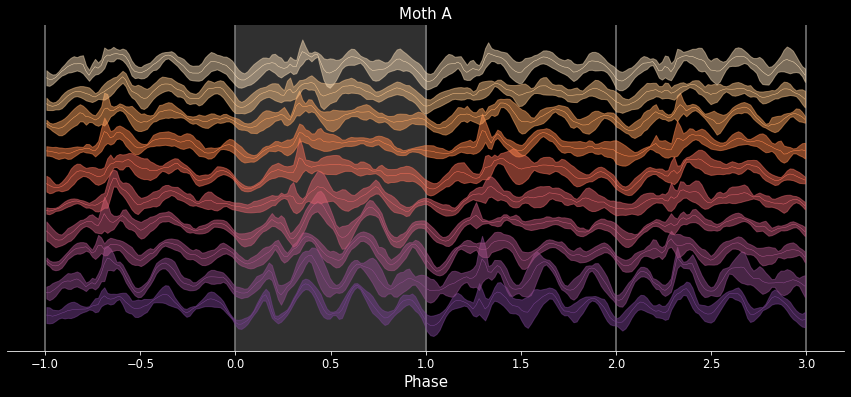

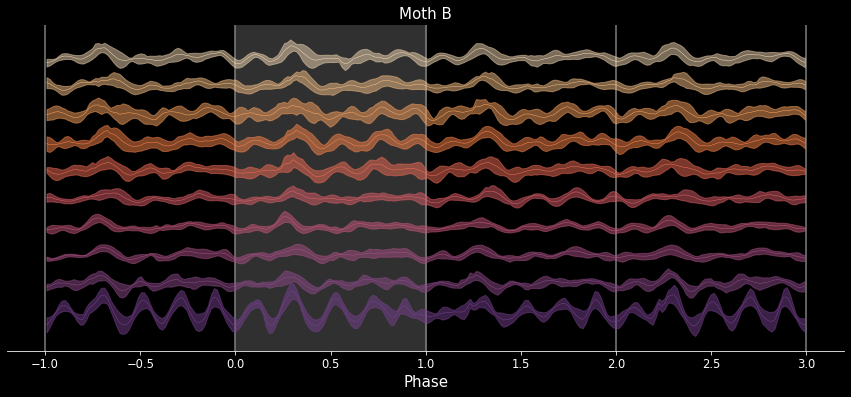

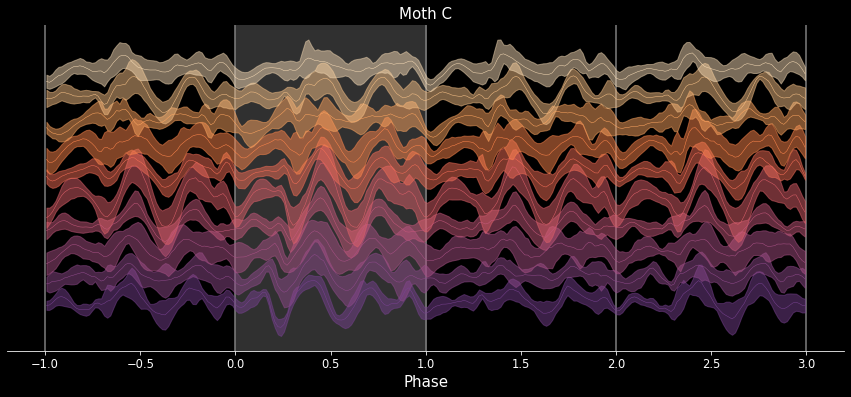

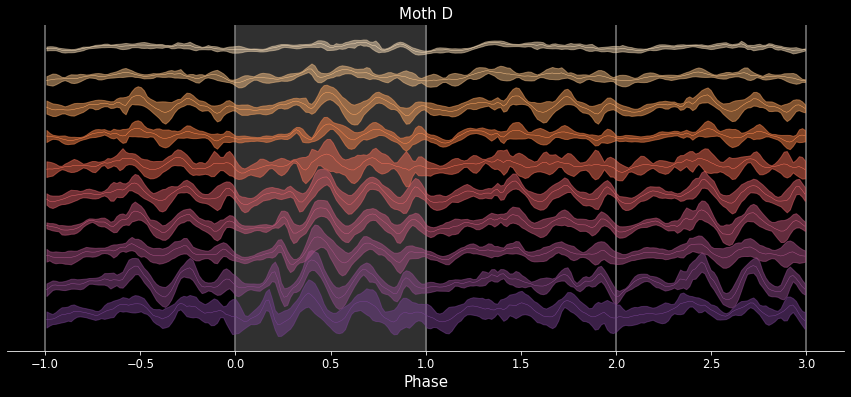

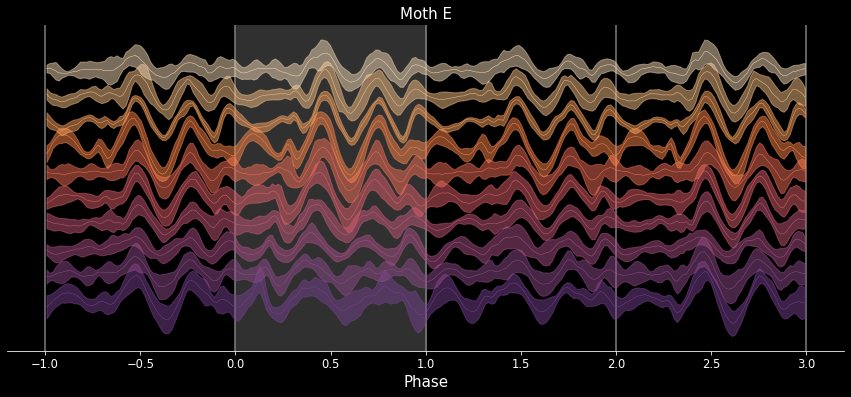

In [72]:
usewb = (-1, 3) # ignore all wingbeat except in this range
ngridx = 250
sep = 2.8 # amount to separate mean traces by 
saveDates = ['20210819','20210818_1','20210817_1']

# viridis = cmx.get_cmap('plasma')
# cmap = cmr.get_sub_cmap('cmr.ember', 0.4, 1)
# cmap = cmr.get_sub_cmap('cmr.infinity', 0.2, 0.8)
# cmap = cmr.get_sub_cmap('cmr.prinsenvlag', 0, 1)
# cmap = cmr.get_sub_cmap('cmr.guppy', 0, 1)
# cmap = cmr.get_sub_cmap('cmr.voltage', 0.3, 0.975)
# cmap = cmr.get_sub_cmap('cmr.lavender', 0.4, 1)
cmap = cmr.get_sub_cmap('cmr.torch', 0.35, 0.9)
# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimfirst)].copy()
                # (df.stimphase<0.5)].copy()
    # Zero time, trim data to region around t=0, change phase to be unique for each wb
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    dt.phase = dt.phase + dt.wb
    # Generate y axis vector
    dt['yvar'] = 0
    dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
    dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
        lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'LDLM_fsphase'].iloc[0]))
    dt = dt.loc[~np.isnan(dt.yvar)]
    # Split by deciles
    dec = np.percentile(dt.yvar, np.arange(0, 100, 10))
    dt['dec'] = np.digitize(dt.yvar, dec)
    # Get mean waveforms for each decile
    xl,yl,gl = binPlot(dt, 'phase', ['mx'], 'dec', 'dec', ngridx+1, makeplot=False)
    
    # Waveform plots
    with plt.style.context('dark_background'):
        plt.figure(figsize=(15,6))
        for i in range(len(xl)):
            plt.fill_between(xl[i]['mean'],
                            sep*i + yl[i]['mean'] - yl[i]['std'],
                            sep*i + yl[i]['mean'] + yl[i]['std'],
                            color=cmap(gl[i]/np.max(gl)),
                            alpha=0.5)
            plt.plot(xl[i]['mean'], sep*i + yl[i]['mean'], color=cmap(gl[i]/np.max(gl)), lw=0.5)
        for i in np.arange(usewb[0],usewb[1]+1):
            plt.axvline(i, color='grey', zorder=0)
        plt.axvspan(xmin=0, xmax=1, color='#303030', zorder=0)
        ax = plt.gca()
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_yticks([])
        plt.xlabel('Phase', fontsize=15)
        plt.title('Moth ' + mothNameDict[d], fontsize=15)
        ax.tick_params(axis='both', which='major', labelsize=11.5)
        if d in saveDates:
            plt.savefig(prespicsdir+'meanstdDecileTraces_'+d+'.png', dpi=300)

CCA explanation figures

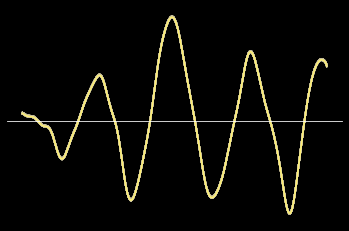

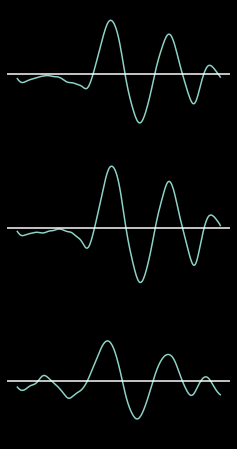

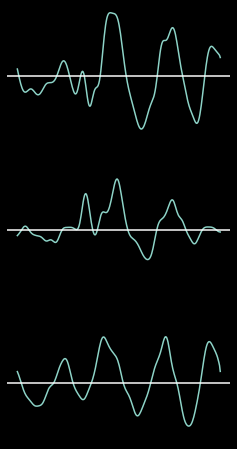

In [96]:
with plt.style.context('dark_background'):
    plt.figure()
    ax = plt.gca()

plt.plot(cca.x_loadings_*xstd + xmeans)
ax.get_yaxis().set_ticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
plt.savefig(prespicsdir+'featureUnscaled.png', dpi=300)

with plt.style.context('dark_background'):
    figfeat, axfeat = plt.subplots(3, 1, figsize=(4,8), sharex=True, sharey=True)
    figactual, axactual = plt.subplots(3, 1, figsize=(4,8), sharex=True, sharey=True)

for i,ii in enumerate([0,10,20]):
    axfeat[i].plot(np.linspace(0,1,300), feats[ii,:])
    axactual[i].plot(np.linspace(0,1,300), Xtrain[ii,:])
    axfeat[i].axhline(0, color='white')
    axactual[i].axhline(0, color='white')
    axfeat[i].axis('off')
    axactual[i].axis('off')
figfeat.savefig(prespicsdir+'first3Feats.png', dpi=300)
figactual.savefig(prespicsdir+'first3Actual.png', dpi=300)
